In [1]:
library(foreach)

source("R/deconvolution.R")
source("R/simulation.R")

Loading required package: pkgmaker

Loading required package: registry

Warning message:
“package ‘registry’ was built under R version 3.5.2”
Loading required package: NMF

Loading required package: rngtools

Loading required package: cluster

NMF - BioConductor layer [OK] | Shared memory capabilities [OK] | Cores 15/16

Loading required package: csSAM

Loading required package: Rcpp

Loading required package: stringr

Warning message:
“package ‘stringr’ was built under R version 3.5.2”
Loading required package: GSEABase

Loading required package: annotate

Warning message:
“package ‘annotate’ was built under R version 3.5.2”
Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: IRanges

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:NMF’:

    nrun


The following object is masked from ‘package:pkgmaker’:

    new2


The following object is masked from ‘package:base’:

 

In [2]:
cl <- parallel::makeCluster(4)
doSNOW::registerDoSNOW(cl)
cl

socket cluster with 4 nodes on host ‘localhost’

# Run experiments

In [56]:
ntypes_variants <- c(3, 4, 5, 6, 7)
reps <- c(1, 2, 3, 4, 5)
noises <- c(2, 5, 5.2, 5.6, 6, 6.3, 6.5, 6.7)
model_names <- c("dsa", "lee", "brunet", "deconf", "linseed", "linseed2")

# DISCUSS: these parameters affect results
n_genes = 12000
n_samples = 40

In [4]:
DATA_ROOT = "data_different_simulations_replicates"

In [5]:
getSimulationFilename <- function(ntypes, rep, noise) {
    paste0(DATA_ROOT, "/simulations/", ntypes, "_", rep, "_", noise, ".rds")
}

saveSimulation <- function(simulation, ntypes, rep, noise) {
    filename <- getSimulationFilename(ntypes, rep, noise)
    saveRDS(simulation, filename)
}

loadSimulation <- function(ntypes, rep, noise) {
    filename <- getSimulationFilename(ntypes, rep, noise)
    readRDS(filename)
}

simulationExists <- function(ntypes, rep, noise) {
    filename <- getSimulationFilename(ntypes, rep, noise)
    file.exists(filename)
}

In [6]:
getExperimentFilename <- function(ntypes, rep, noise, model_name) {
    paste0(DATA_ROOT, "/experiments/", ntypes, "_", rep, "_", noise, "_", model_name, ".rds")
}

saveExperiment <- function(experiment, ntypes, rep, noise, model_name) {
    filename <- getExperimentFilename(ntypes, rep, noise, model_name)
    saveRDS(experiment, filename)
}

loadExperiment <- function(ntypes, rep, noise, model_name) {
    filename <- getExperimentFilename(ntypes, rep, noise, model_name)
    readRDS(filename)    
}

experimentExists <- function(ntypes, rep, noise, model_name) {
    filename <- getExperimentFilename(ntypes, rep, noise, model_name)
    file.exists(filename)   
}

## Create simulations

In [241]:
for (ntypes in ntypes_variants) {
    message(paste(ntypes, "cell types"))
    for (rep in reps) {
        if (!simulationExists(ntypes, rep, 0)) {
            message(paste("Generating data for replicate", rep))
            simulation <- createSimulation(n_genes = n_genes, n_samples = n_samples, n_cell_types = ntypes)
            simulation <- withPureSamples(simulation, samples_per_cell_type = 3)
            simulation <- withBasisSamples(simulation)
            simulation <- withDeMarkerList(simulation)
            saveSimulation(simulation, ntypes, rep, 0)
            for (noise in noises) {
                sims_with_noise <- list()
                noise_r2s <- list()
                for (i in 1:100) {
                    sim_with_noise <- withNoise(simulation, noise)
                    sims_with_noise[[i]] <- sim_with_noise
                    noise_r2s[[i]] <- r2(
                        sim_with_noise$data[, sim_with_noise$basis_sample_names],
                        sim_with_noise$basis
                    )
                }
                noise_r2s <- unlist(noise_r2s)
                median_noise_idx <- which.min(abs(noise_r2s - median(noise_r2s)))
                sim_with_noise <- sims_with_noise[[median_noise_idx]]
                noise_r2 <- noise_r2s[median_noise_idx]
                message(paste0("Noise: ", sim_with_noise$data_noise_deviation, ", R2: ", noise_r2))
                saveSimulation(sim_with_noise, ntypes, rep, noise)
            }
        } else {
            message(paste("Replicate", rep, "is already generated"))
        }
    }
}

3 cell types

Replicate 1 is already generated

Replicate 2 is already generated

Replicate 3 is already generated

Replicate 4 is already generated

Replicate 5 is already generated

4 cell types

Replicate 1 is already generated

Replicate 2 is already generated

Replicate 3 is already generated

Replicate 4 is already generated

Replicate 5 is already generated

5 cell types

Replicate 1 is already generated

Generating data for replicate 2

Noise: 2, R2: 0.999999999890344

Noise: 5, R2: 0.999527309044773

Noise: 5.2, R2: 0.998077615858406

Noise: 5.6, R2: 0.980539254770852

Noise: 6, R2: 0.885337777972771

Noise: 6.3, R2: 0.61411789313641

Noise: 6.5, R2: 0.236186610524716

Noise: 6.7, R2: 0.0913681269459181

Replicate 3 is already generated

Replicate 4 is already generated

Replicate 5 is already generated

6 cell types

Replicate 1 is already generated

Replicate 2 is already generated

Replicate 3 is already generated

Replicate 4 is already generated

Replicate 5 is already ge

In [242]:
sim_noise_r2s <- data.frame(matrix(ncol=4, nrow=0))
colnames(sim_noise_r2s) <- c("ntypes", "rep", "noise", "noise_r2")
for (ntypes in ntypes_variants) {
    for (rep in reps) {
        for (noise in noises) {
            sim <- loadSimulation(ntypes, rep, noise)
            noise_r2 <- r2(sim$data[, sim$basis_sample_names], sim$basis)
            sim_noise_r2s[nrow(sim_noise_r2s) + 1,] <- c(ntypes, rep, noise, noise_r2)
        }
    }
}
sim_noise_r2s$ntypes <- as.factor(sim_noise_r2s$ntypes)
sim_noise_r2s$rep <- as.factor(sim_noise_r2s$rep)

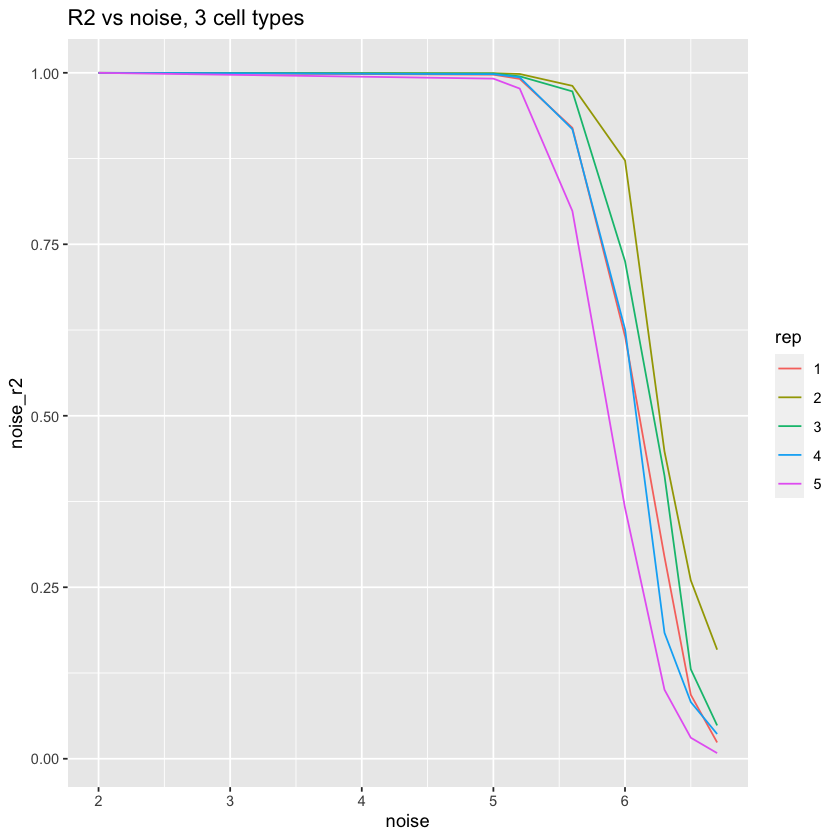

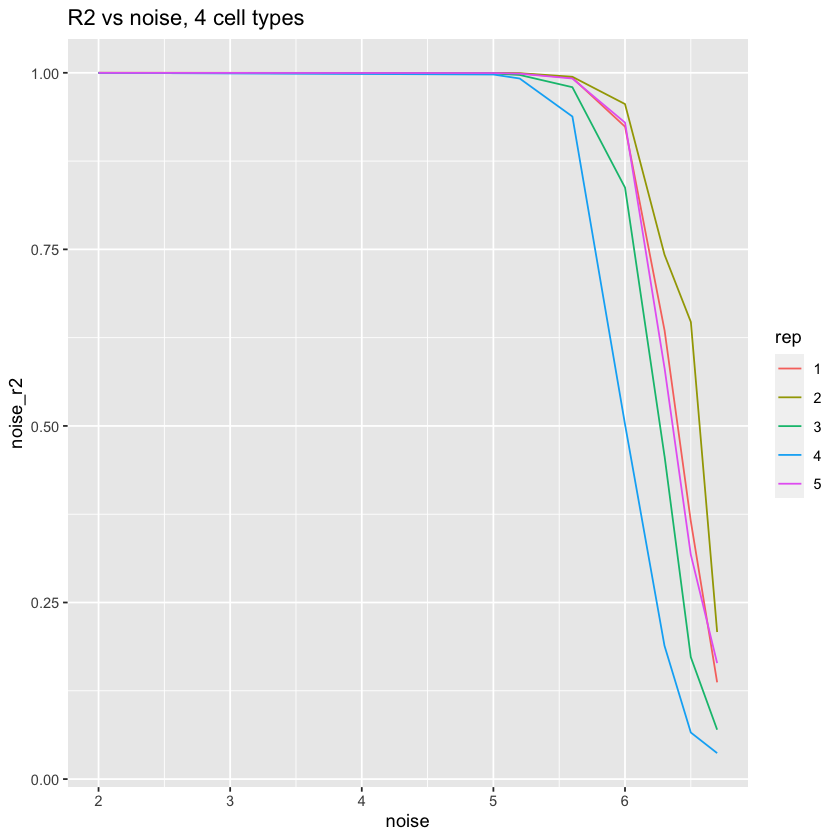

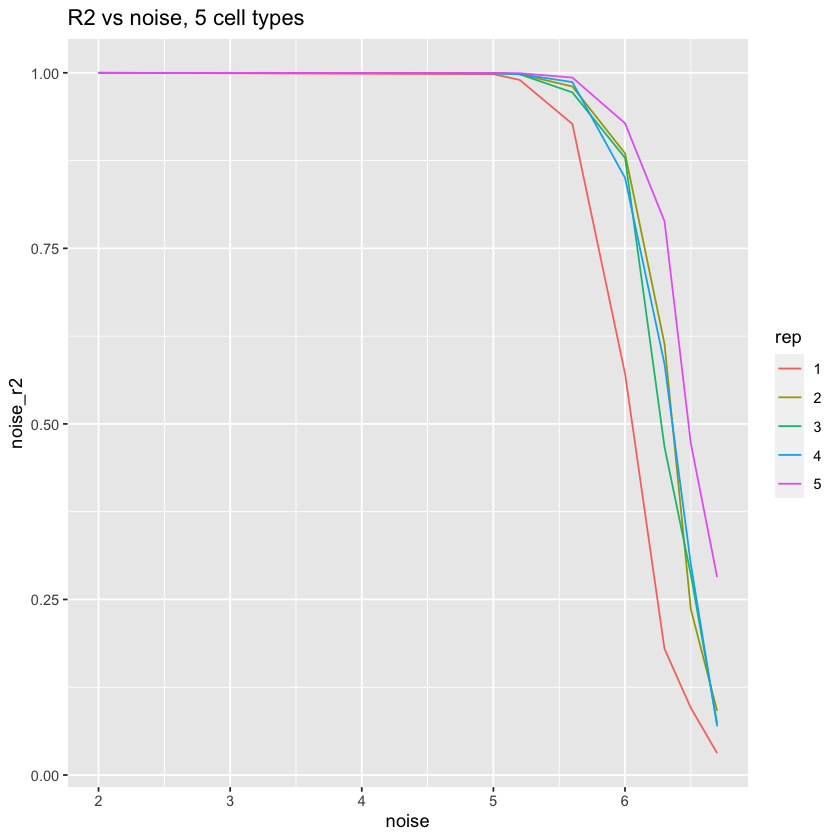

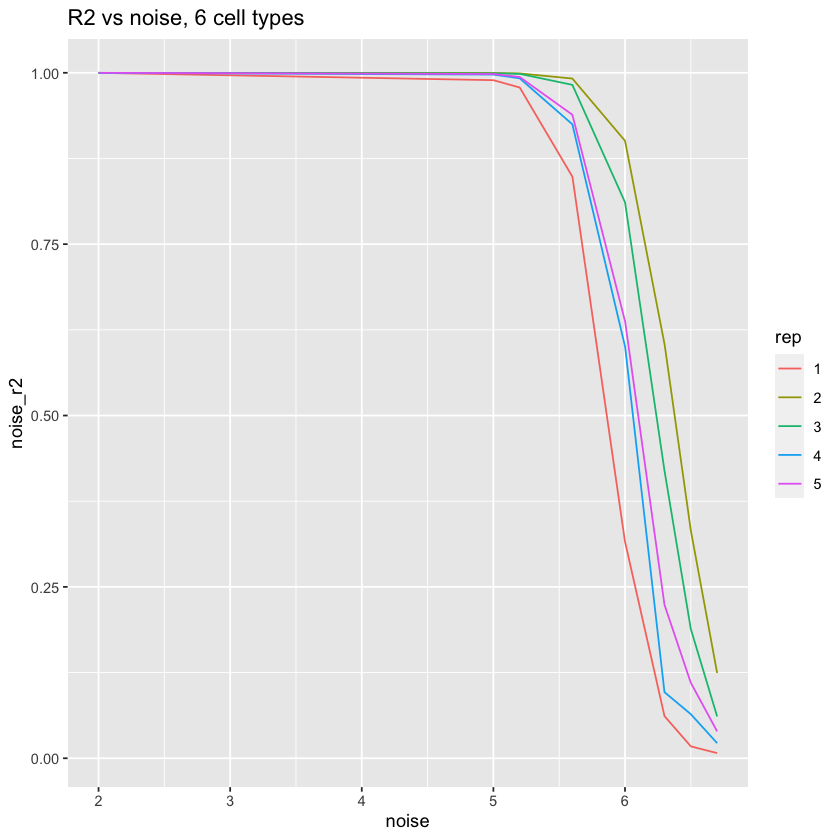

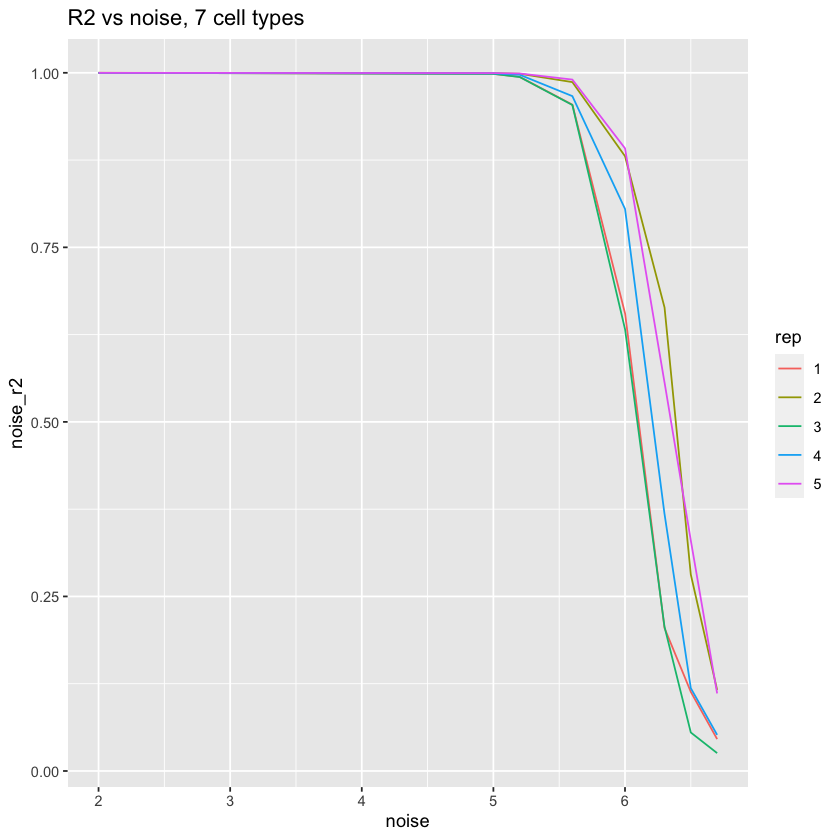

In [243]:
for (ntypes in ntypes_variants) {
    show(
        ggplot(
            sim_noise_r2s[sim_noise_r2s$ntypes == ntypes,],
            aes(x = noise, y = noise_r2, col = rep)
        ) + geom_line() + ggtitle(paste("R2 vs noise,", ntypes, "cell types"))
    )
}

## Fit models

In [67]:
tmp <- foreach(ntypes = ntypes_variants) %:%
        foreach(rep = reps) %:%
        foreach(noise = noises) %:%
        foreach(model_name = model_names) %dopar% {
            source("R/deconvolution.R")
            if (!experimentExists(ntypes, rep, noise, model_name)) {
                simulation <- loadSimulation(ntypes, rep, noise)
                data <- simulation$data[, simulation$mixed_sample_names]
                fit <- fitDeconvolutionModel(simulation$data, model_name, ntypes, simulation$marker_list, TRUE)
                if (model_name == "linseed") {
                    exp <- list(
                        proportions = fit$proportions,
                        signatures = fit$signatures
                    )
                } else if (model_name == "linseed2") {
                    rownames(fit$full_basis) <- fit$top_genes
                    exp <- list(
                        proportions = fit$full_proportions,
                        signatures = fit$full_basis
                    )
                } else {
                    exp <- list(
                        proportions = coef(fit),
                        signatures = basis(fit)
                    )
                }
                saveExperiment(exp, ntypes, rep, noise, model_name)
                gc()
            }
            NULL
        }

# Calculate metrics

In [57]:
getExperimentPredTrueBasis <- function(experiment, simulation) {
    pred_basis <- experiment$signatures    
    true_basis <- simulation$basis[rownames(pred_basis), ]
    pred_basis <- pred_basis[, guessOrder(t(pred_basis), t(true_basis))]
    list(pred = pred_basis, true = true_basis)
}

getExperimentPredTrueProps <- function(experiment, simulation) {
    pred_props <- experiment$proportions
    true_props <- simulation$proportions
    pred_props <- pred_props[guessOrder(pred_props, true_props), ]
    list(pred = pred_props, true = true_props)
}

In [58]:
getExperimentTableFilename <- function() {
    paste0(
        DATA_ROOT, "/",
        paste(ntypes_variants, collapse=","),
        "_", paste(reps, collapse=","),
        "_", paste(noises, collapse=","),
        "_", paste(model_names, collapse=","),
        ".rds"
    )
}

saveExperimentTable <- function(table) {
    saveRDS(table, getExperimentTableFilename())
}

loadExperimentTable <- function() {
    readRDS(getExperimentTableFilename())
}

In [61]:
experiment_table <- data.table::CJ(ntypes_variants, reps, noises, model_names)
colnames(experiment_table) <- c("ntypes", "rep", "noise", "model")
head(experiment_table)

ntypes rep noise model   
1 3      1   2     brunet  
2 3      1   2     deconf  
3 3      1   2     dsa     
4 3      1   2     lee     
5 3      1   2     linseed 
6 3      1   2     linseed2

In [62]:
for (i in 1:nrow(experiment_table)) {    
    exp <- loadExperiment(
        experiment_table[i, "ntypes"],
        experiment_table[i, "rep"],
        experiment_table[i, "noise"],
        experiment_table[i, "model"]
    )
    sim <- loadSimulation(
        experiment_table[i, "ntypes"],
        experiment_table[i, "rep"],
        experiment_table[i, "noise"]
    )
    props <- getExperimentPredTrueProps(exp, sim)
    
    experiment_table[i, "proportions_r2"] <- r2(props$true, props$pred)
    experiment_table[i, "proportions_rmse"] <- rmse(props$true, props$pred)
    experiment_table[i, "proportions_nrmse"] <- experiment_table[i, "proportions_rmse"] / IQR(props$true)
}

In [68]:
for (i in 1:nrow(experiment_table)) {    
    exp <- loadExperiment(
        experiment_table[i, "ntypes"],
        experiment_table[i, "rep"],
        experiment_table[i, "noise"],
        experiment_table[i, "model"]
    )
    sim <- loadSimulation(
        experiment_table[i, "ntypes"],
        experiment_table[i, "rep"],
        experiment_table[i, "noise"]
    )

    basis <- getExperimentPredTrueBasis(exp, sim)
    
    experiment_table[i, "basis_r2"] <- r2(basis$true, basis$pred)
    experiment_table[i, "basis_rmse"] <- rmse(basis$true, basis$pred)
    experiment_table[i, "basis_nrmse"] <- experiment_table[i, "basis_rmse"] / IQR(basis$true)
}

In [69]:
head(experiment_table)

ntypes rep noise model    proportions_r2 proportions_rmse proportions_nrmse
1 3      1   2     brunet   0.9962018      0.019015509      0.04095919       
2 3      1   2     deconf   0.9951697      0.024698108      0.05319945       
3 3      1   2     dsa      0.9858499      0.044308821      0.09544070       
4 3      1   2     lee      0.9887649      0.038636839      0.08322331       
5 3      1   2     linseed  0.9995549      0.007759717      0.01671434       
6 3      1   2     linseed2 0.9992200      0.009451853      0.02035918       
  basis_r2     basis_rmse   basis_nrmse 
1 0.9952318280 2.277776e+08 1.708838e+05
2 0.2177625249 2.286387e+05 1.715298e+02
3 0.9977977257 1.221004e+04 9.160242e+00
4 0.9896668067 7.904964e+06 5.930478e+03
5 0.9998731416 2.961077e+03 1.481816e+00
6 0.0000564896 1.127446e+06 7.926414e+00

In [70]:
saveExperimentTable(experiment_table)

In [71]:
pure_data_table <- data.table::CJ(ntypes_variants, reps, noises, "pure_data")
colnames(pure_data_table) <- c("ntypes", "rep", "noise", "model")
for (i in 1:nrow(pure_data_table)) {
    sim <- loadSimulation(
        pure_data_table[i, "ntypes"],
        pure_data_table[i, "rep"],
        pure_data_table[i, "noise"]
    )
    pure_data_table[i, "basis_r2"] <- r2(sim$data[, sim$basis_sample_names], sim$basis)
    pure_data_table[i, "basis_rmse"] <- rmse(sim$data[, sim$basis_sample_names], sim$basis)
    pure_data_table[i, "basis_nrmse"] <- pure_data_table[i, "basis_rmse"] / mean(sim$data[, sim$basis_sample_names])
}
head(pure_data_table)

ntypes rep noise model     basis_r2  basis_rmse   basis_nrmse 
1 3      1   2.0   pure_data 1.0000000 6.701438e+00 5.843341e-04
2 3      1   5.0   pure_data 0.9972897 1.190878e+04 1.010006e+00
3 3      1   5.2   pure_data 0.9911178 2.162263e+04 1.807098e+00
4 3      1   5.6   pure_data 0.9197855 6.744032e+04 5.213881e+00
5 3      1   6.0   pure_data 0.6159685 1.802596e+05 1.218481e+01
6 3      1   6.3   pure_data 0.2942147 3.533652e+05 1.932840e+01

# Plots

In [72]:
experiment_table <- loadExperimentTable()

In [73]:
head(experiment_table)

ntypes rep noise model    proportions_r2 proportions_rmse proportions_nrmse
1 3      1   2     brunet   0.9962018      0.019015509      0.04095919       
2 3      1   2     deconf   0.9951697      0.024698108      0.05319945       
3 3      1   2     dsa      0.9858499      0.044308821      0.09544070       
4 3      1   2     lee      0.9887649      0.038636839      0.08322331       
5 3      1   2     linseed  0.9995549      0.007759717      0.01671434       
6 3      1   2     linseed2 0.9992200      0.009451853      0.02035918       
  basis_r2     basis_rmse   basis_nrmse 
1 0.9952318280 2.277776e+08 1.708838e+05
2 0.2177625249 2.286387e+05 1.715298e+02
3 0.9977977257 1.221004e+04 9.160242e+00
4 0.9896668067 7.904964e+06 5.930478e+03
5 0.9998731416 2.961077e+03 1.481816e+00
6 0.0000564896 1.127446e+06 7.926414e+00

## Plotting functions

In [74]:
validatePlottingArgs <- function(arr_type, metric_name, on, fixed, comparing) {
    comparing_options <- c("model", "noise", "ntypes")
    stopifnot(metric_name %in% c("r2", "rmse", "nrmse"))
    stopifnot(arr_type %in% c("basis", "proportions"))
    stopifnot(on %in% comparing_options)
    stopifnot(fixed %in% comparing_options)
    stopifnot(comparing %in% comparing_options)
    stopifnot((on != fixed) && (on != comparing) && (fixed != comparing))
    TRUE
}

In [75]:
getMetricRepr <- function(metric_name) {
    if (metric_name == "r2") {
        metric_repr <- "R^2"
    } else if (metric_name == "rmse") {
        metric_repr <- "RMSE"
    } else {
        metric_repr <- "NRMSE"
    }
    metric_repr
}

In [76]:
comparing_options_reprs <- list(
    "model" = "Model",
    "noise" = "Noise deviation",
    "ntypes" = "Cell types number"
)

In [77]:
plotPureDataMetric <- function(on) {
    stopifnot(on %in% c("noise", "ntypes"))
    reprs <- comparing_options_reprs
    data <- as.data.frame(
        melt(
            pure_data_table,
            id.vars=c("ntypes", "model", "noise", "rep"),
            variable.name = "metric_name",
            value.name = "metric_value"
        )
    )
    if (on == "noise") {
        comparing = "ntypes"
    } else {
        comparing = "noise"
    }
    data[, comparing] <- as.factor(data[, comparing])
    
    
    ggplot(data, aes_string(on, "metric_value", col = comparing)) +
        geom_line() +
        geom_point() +
        facet_wrap(~ metric_name, scales = "free") +
        ylab("Metric value") +
        xlab(reprs[[on]]) +
        labs(colour = reprs[[comparing]]) +
        ggtitle(glue::glue("Pure vs noisy expressions"))
}

In [78]:
plotMetric <- function(arr_type, metric_name, on, fixed, comparing) {
    validatePlottingArgs(arr_type, metric_name, on, fixed, comparing)
    metric_repr <- getMetricRepr(metric_name)
    reprs <- comparing_options_reprs
    
    if (arr_type == "basis") {
        data <- rbind(
            experiment_table[
                ,
                colnames(experiment_table)[!startsWith(colnames(experiment_table), "proportions")],
                with=F
            ],
            pure_data_table
        )
    } else {
        data <- experiment_table
    }
    
    col <- paste0(arr_type, "_", metric_name)
    data <- data[, .(metric_mean=mean(get(col)), metric_sd=sd(get(col))), by=list(ntypes, noise, model)]
    
    data <- as.data.frame(data)
    data[, comparing] <- as.factor(data[, comparing])
    
    ggplot(data, aes_string(on, "metric_mean", col = comparing)) +
        geom_line() +
        geom_point() +
        geom_errorbar(
            aes(
                ymin=metric_mean-metric_sd,
                ymax=metric_mean+metric_sd
            ),
            width=.1,
            position=position_dodge(0.01)
        ) +
        facet_wrap(as.formula(paste("~", fixed))) +
        ylab(glue::glue("{metric_repr}, mean across 3 replicates")) +
        xlab(reprs[[on]]) +
        labs(colour = reprs[[comparing]]) +
        ggtitle(glue::glue("Dependence of {metric_repr} (true vs predicted {arr_type}) on {tolower(reprs[[on]])} with fixed {tolower(reprs[[fixed]])}s"))

}

In [79]:
metrics <- c("r2", "rmse", "nrmse")
arr_types <- c("basis", "proportions")
plotAll <- function(dependence_on, fixed, comparing) {
    for (arr_type in arr_types) {
        for (metric_name in metrics) {
            # Workaround, bad predictions spoil plots
            if (arr_type != "basis" || metric_name == "r2") {
                show(plotMetric(
                    arr_type,
                    metric_name,
                    on = dependence_on,
                    fixed = fixed,
                    comparing = comparing
                ))
            }
        }
    }
}

## Draw plots

In [80]:
options(repr.plot.width=16, repr.plot.height=8)

### Metric on noise, fixed number of cell types (comparing models)

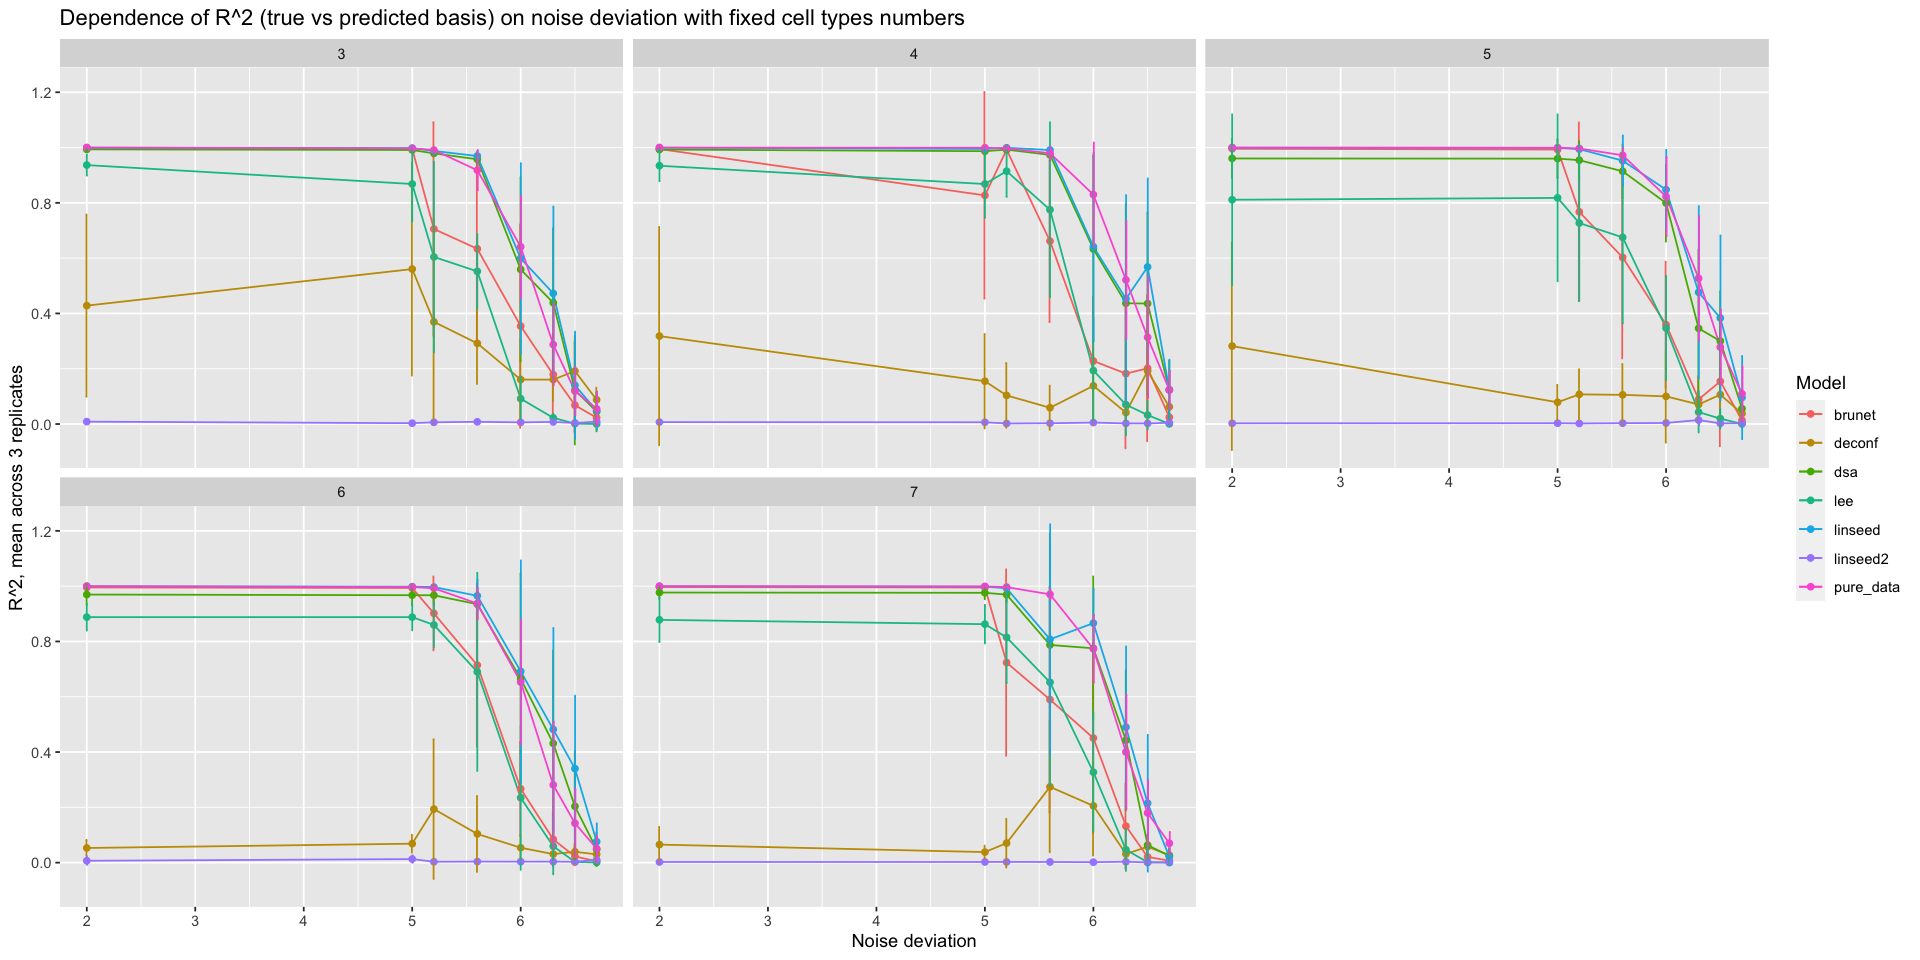

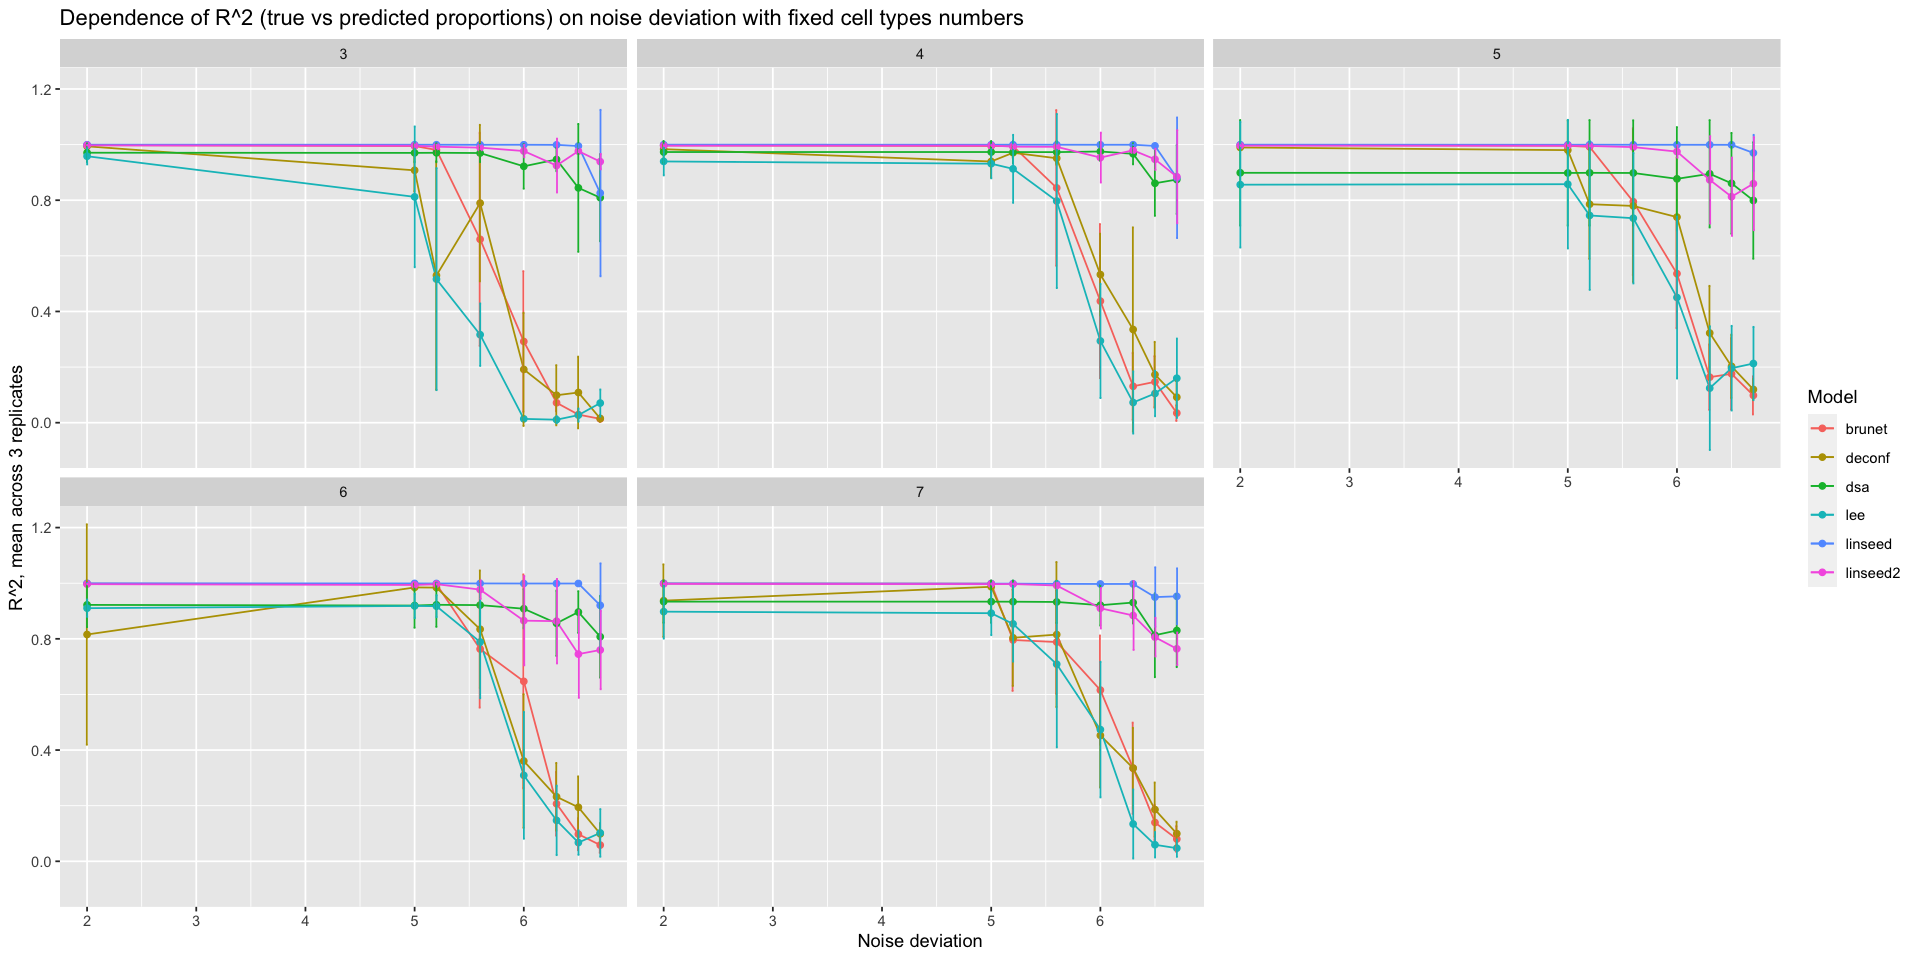

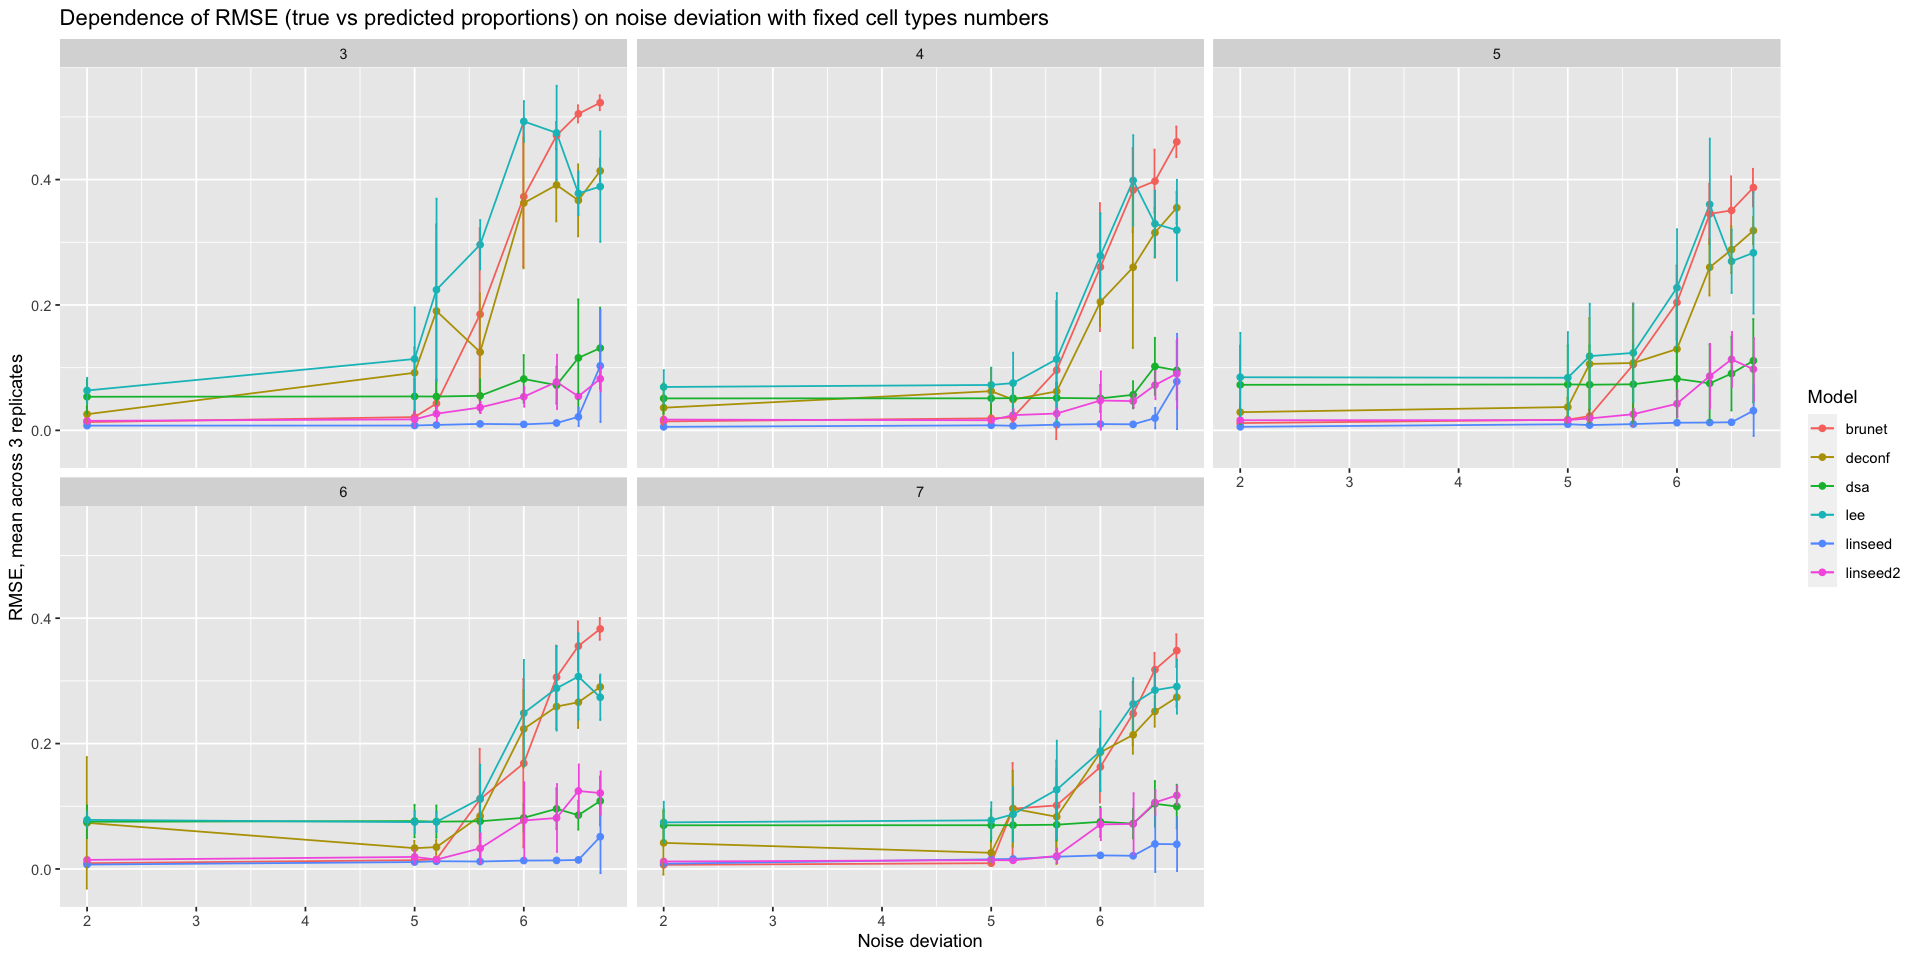

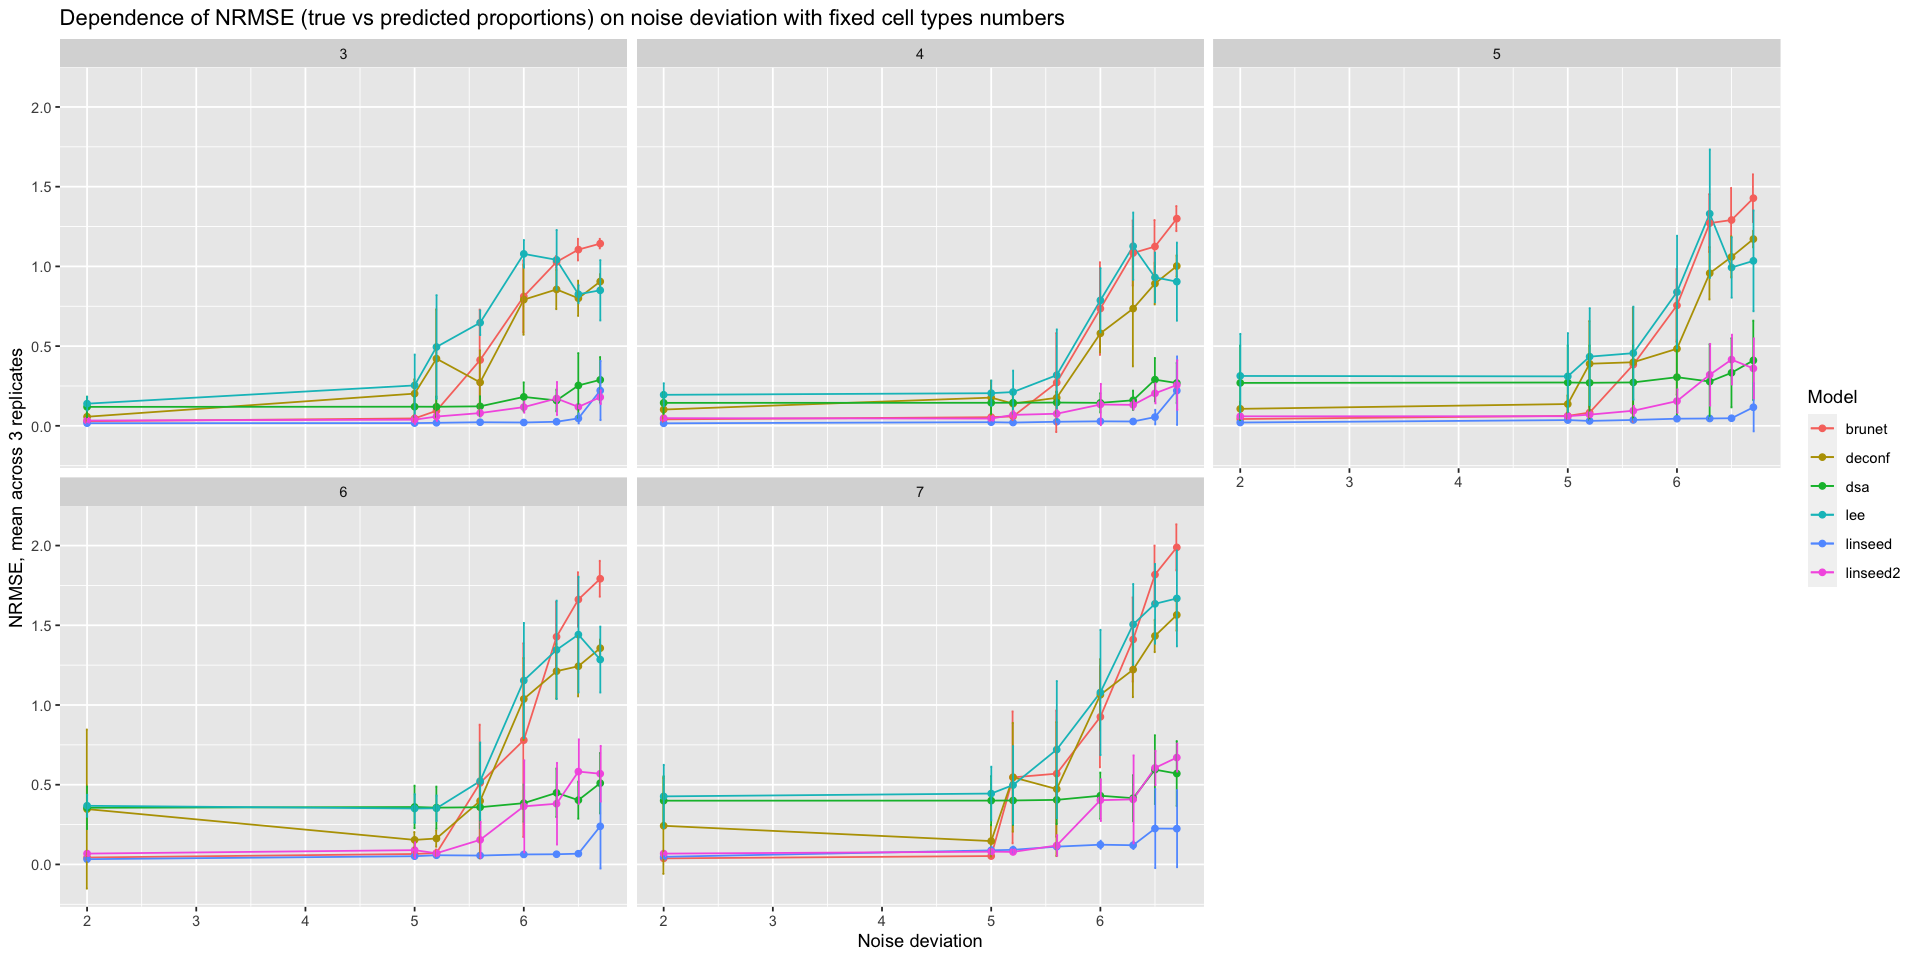

In [82]:
plotAll(dependence_on = "noise", fixed = "ntypes", comparing = "model")

### Metric on number of types, fixed noise (comparing models)

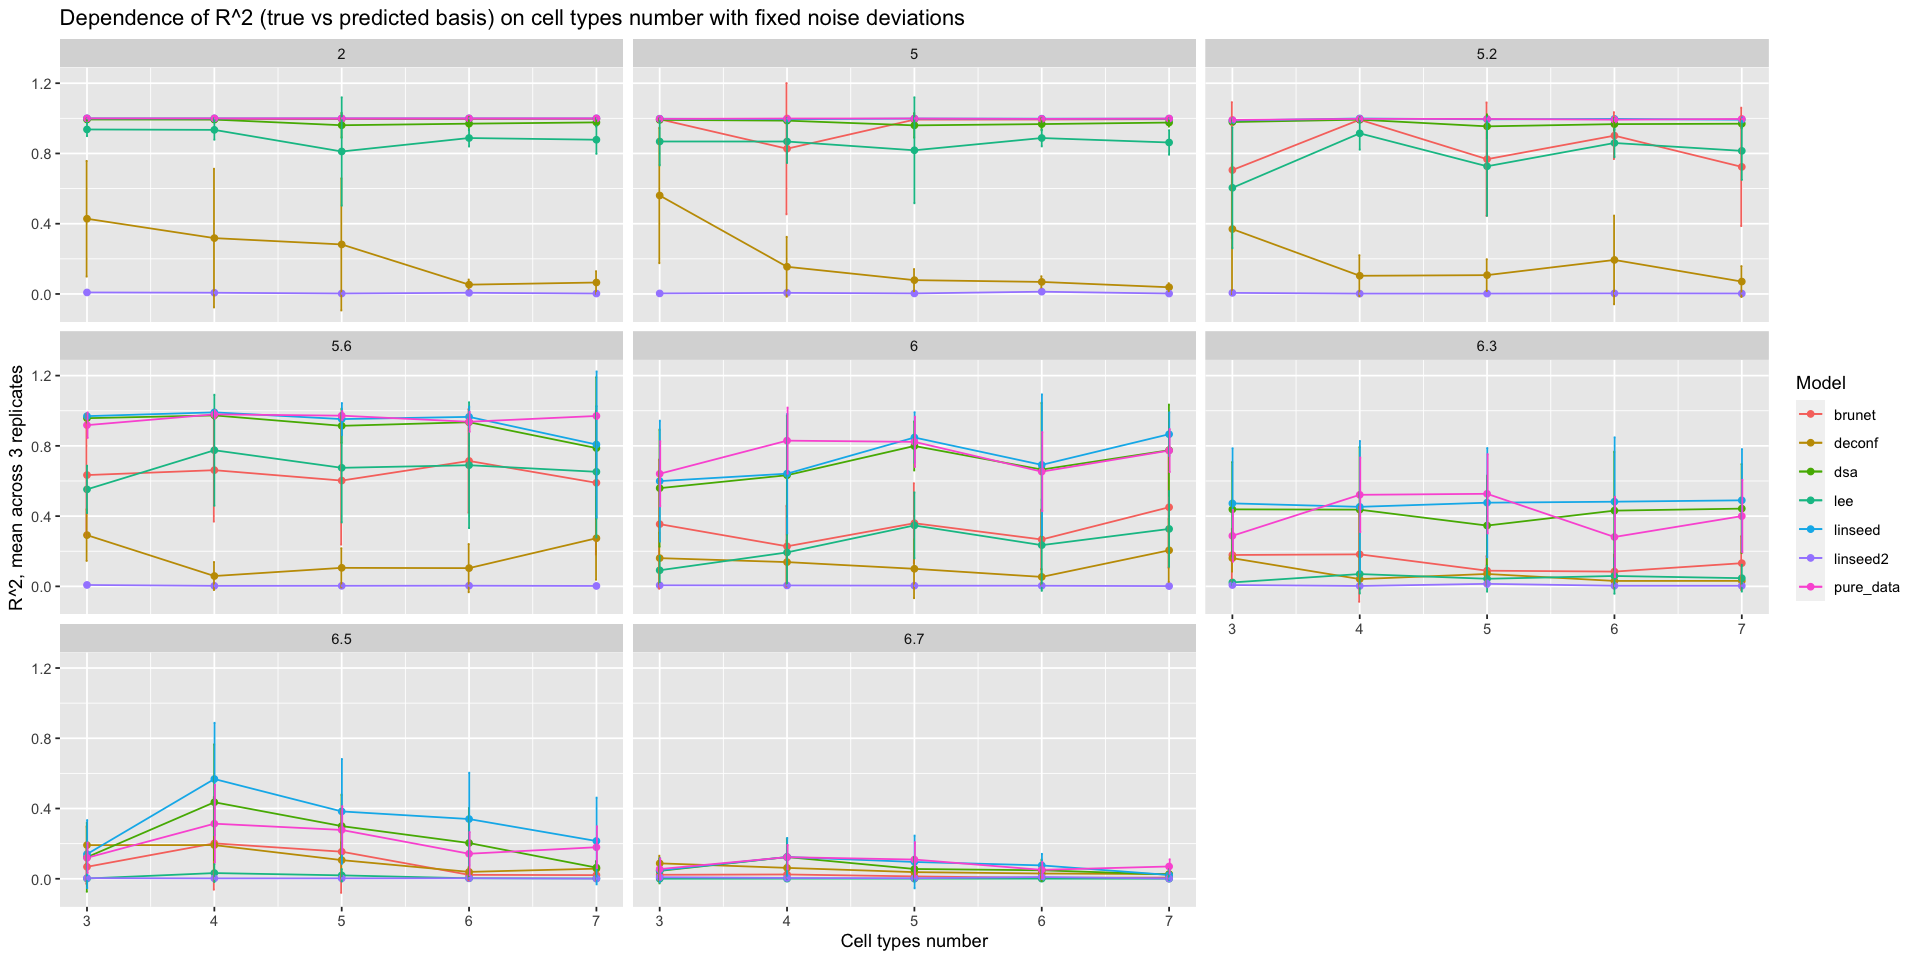

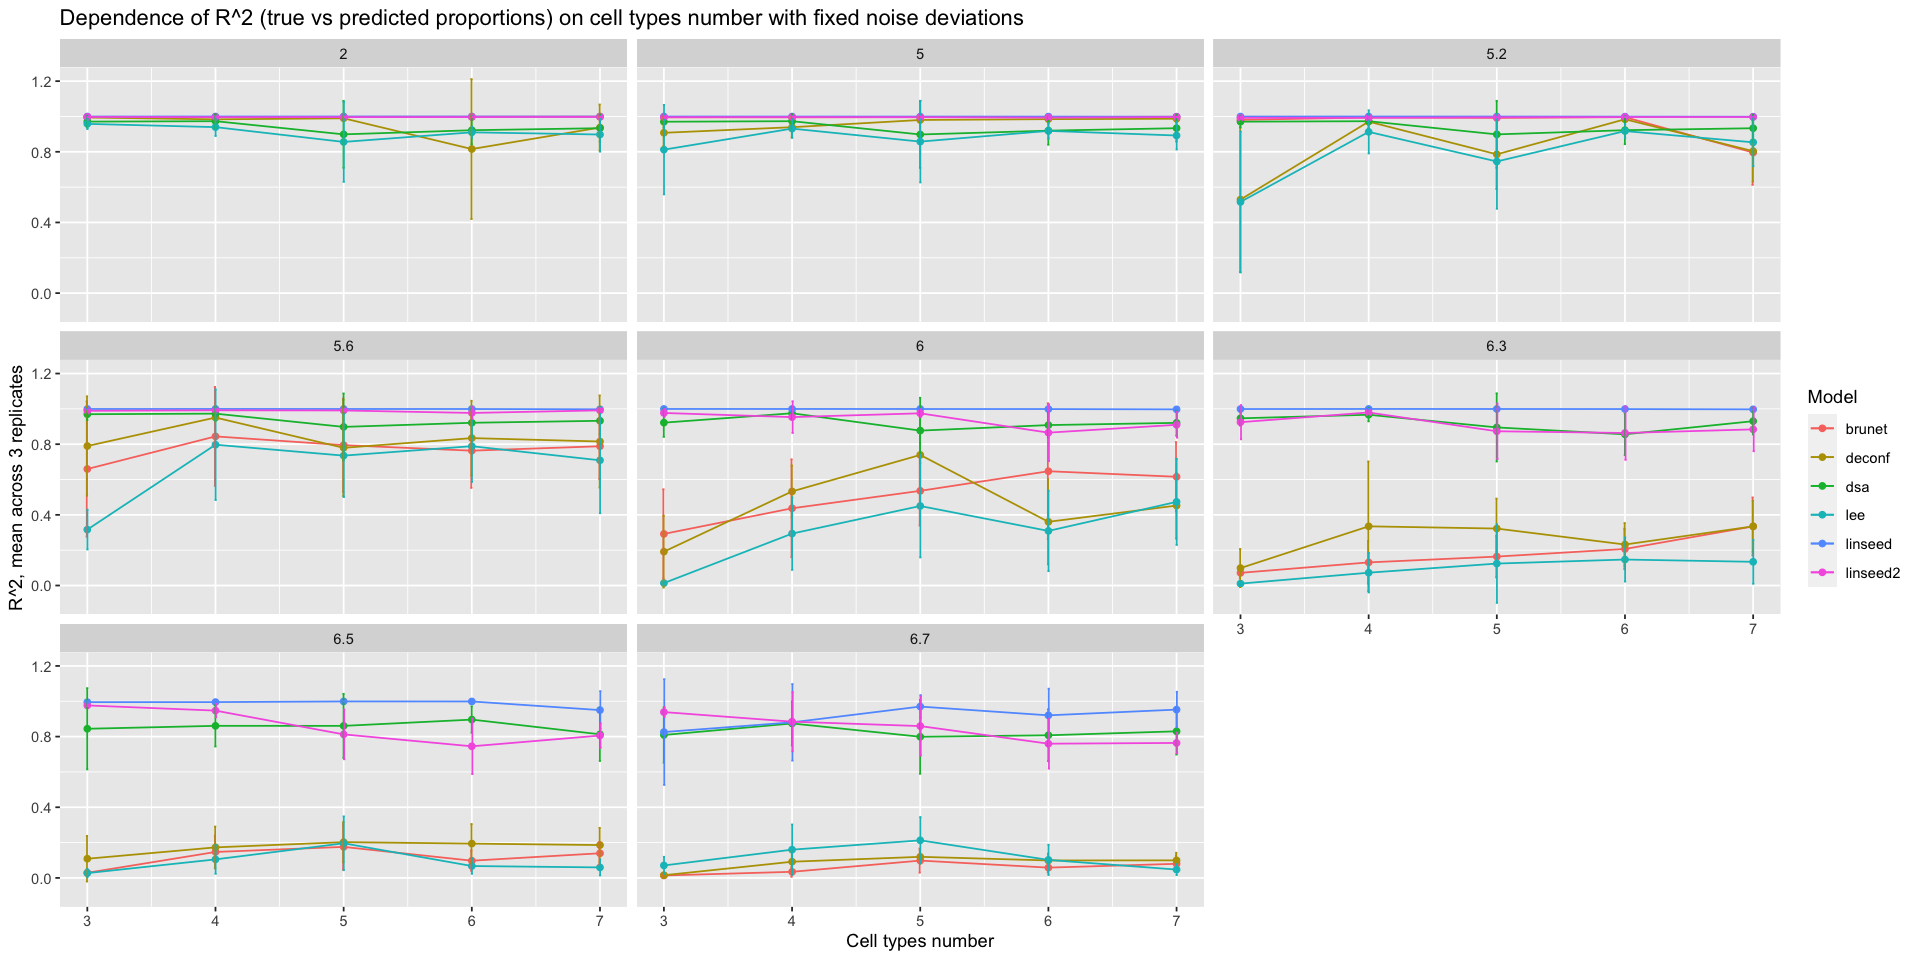

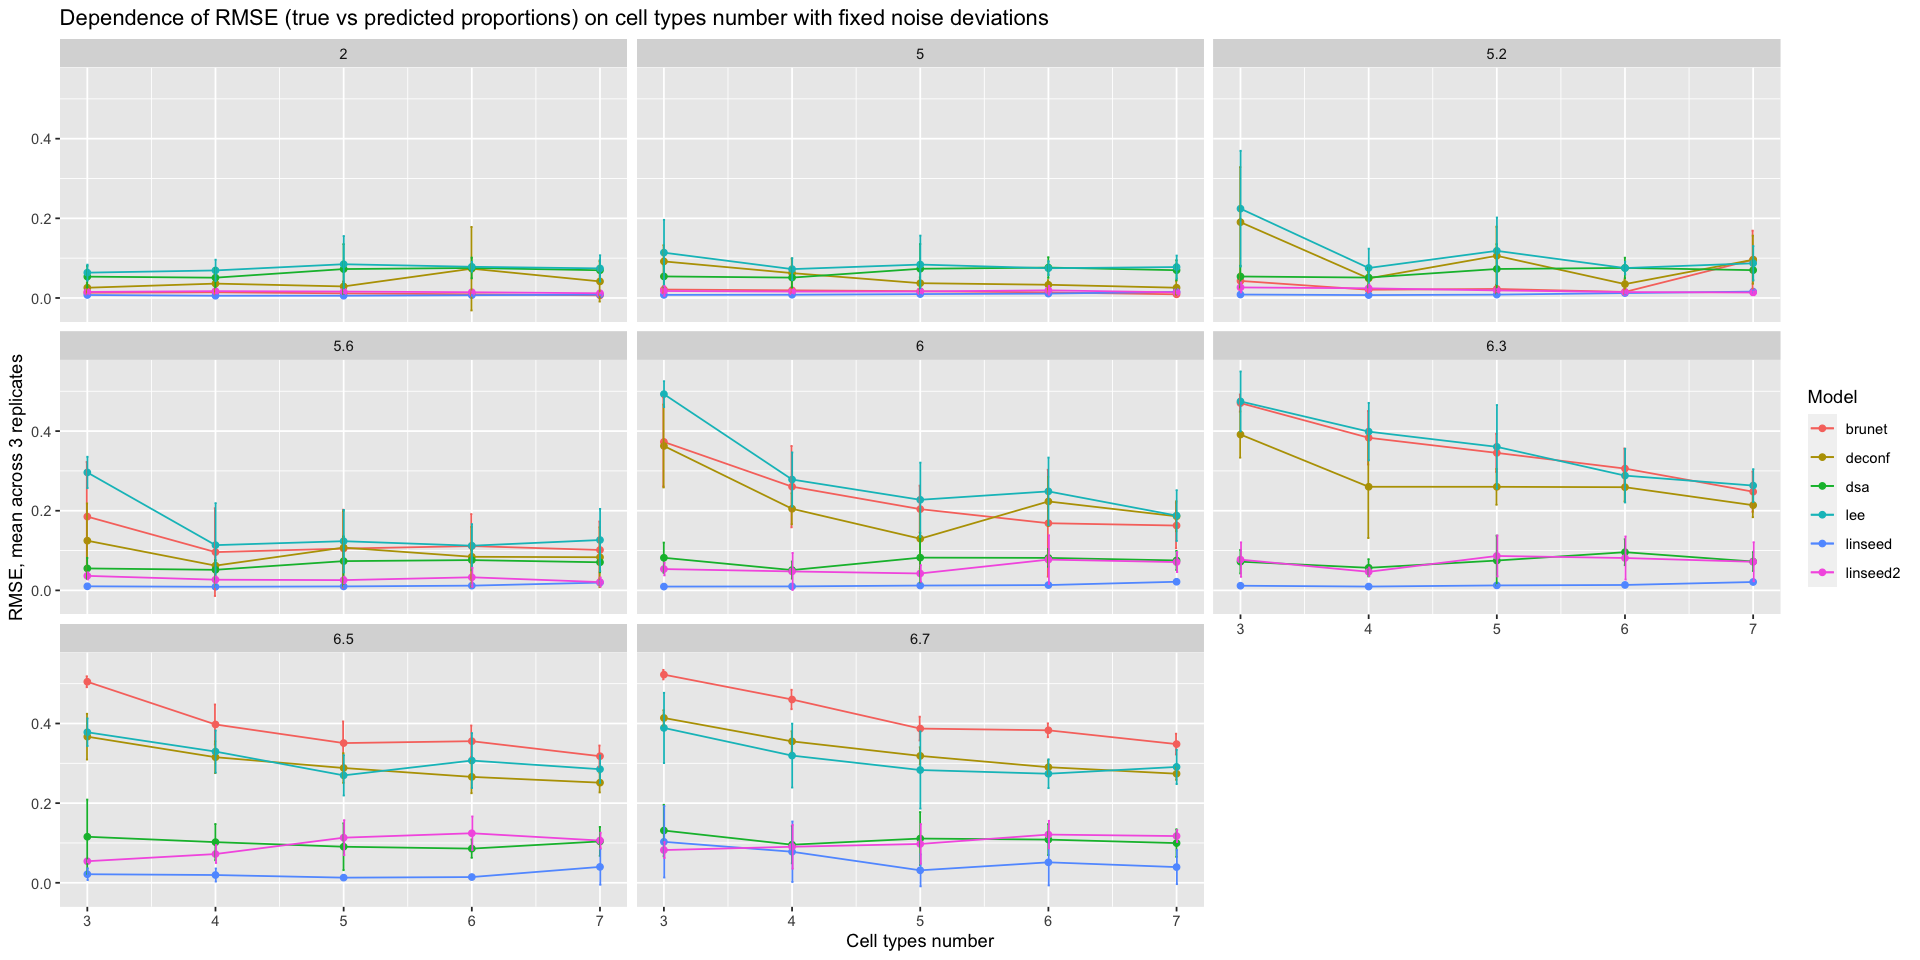

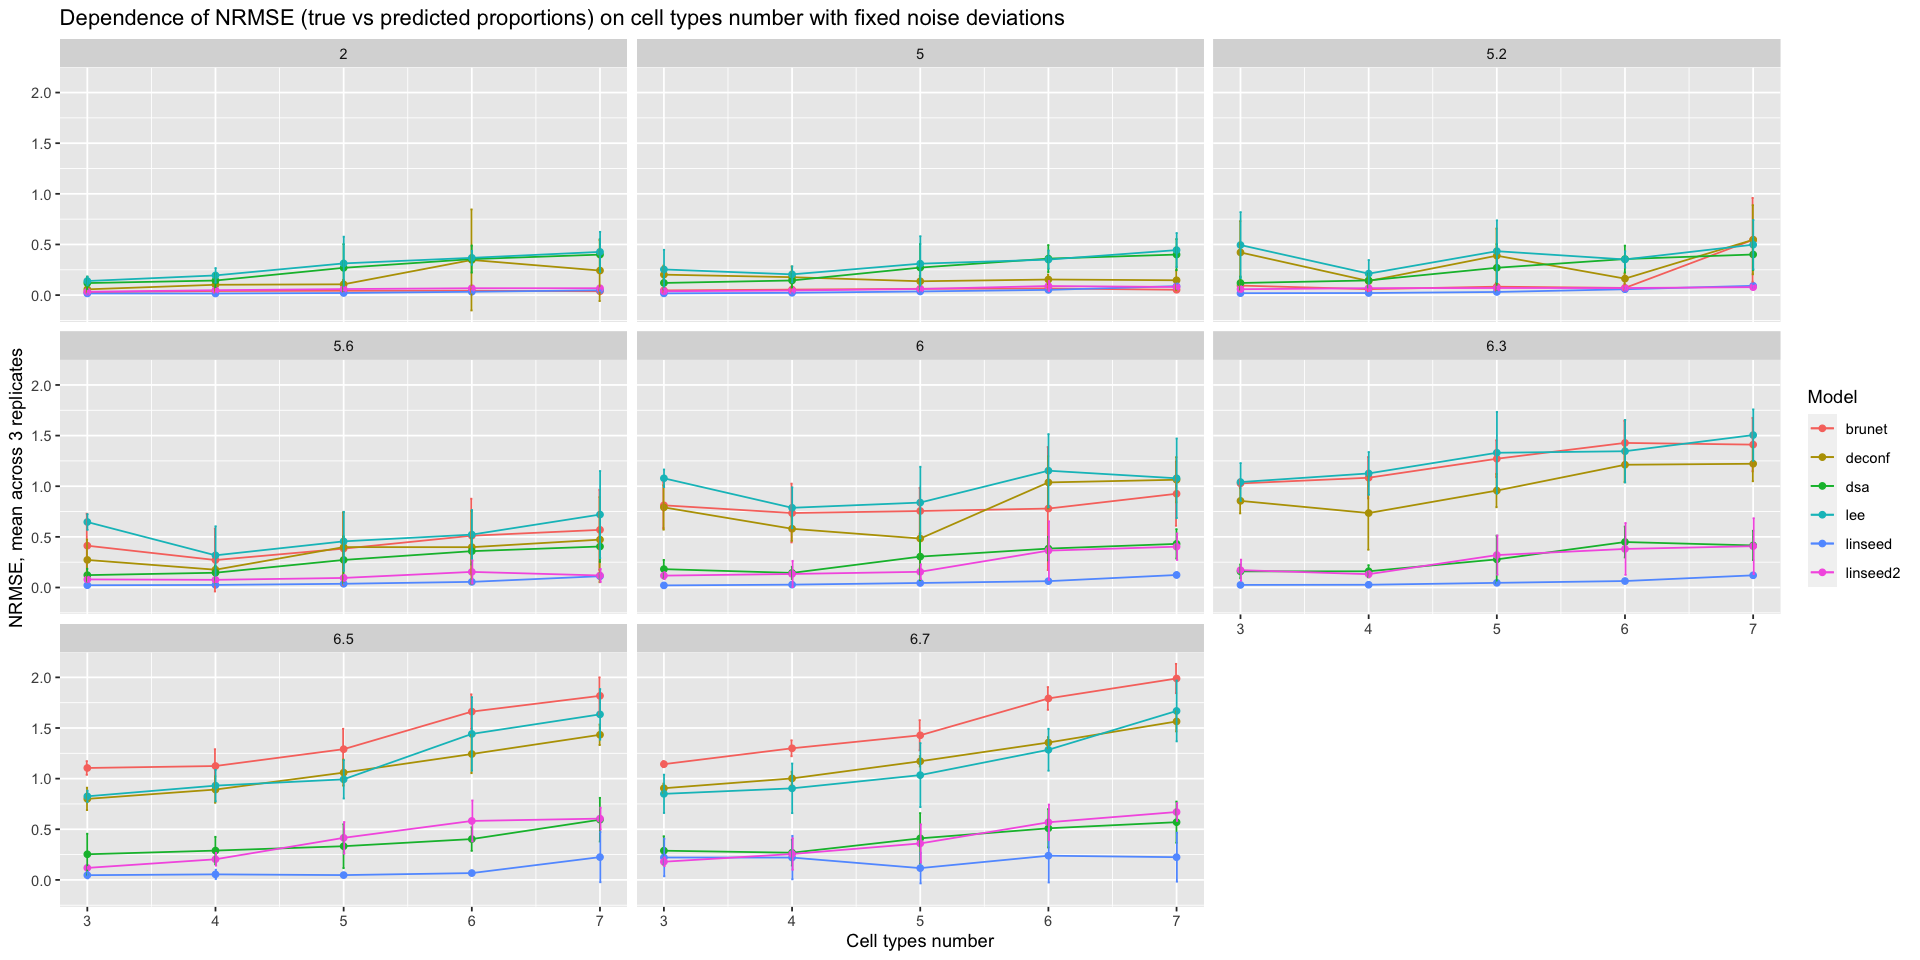

In [83]:
plotAll(dependence_on = "ntypes", fixed = "noise", comparing = "model")

### Metric on noise, fixed model (comparing numbers of cell types)

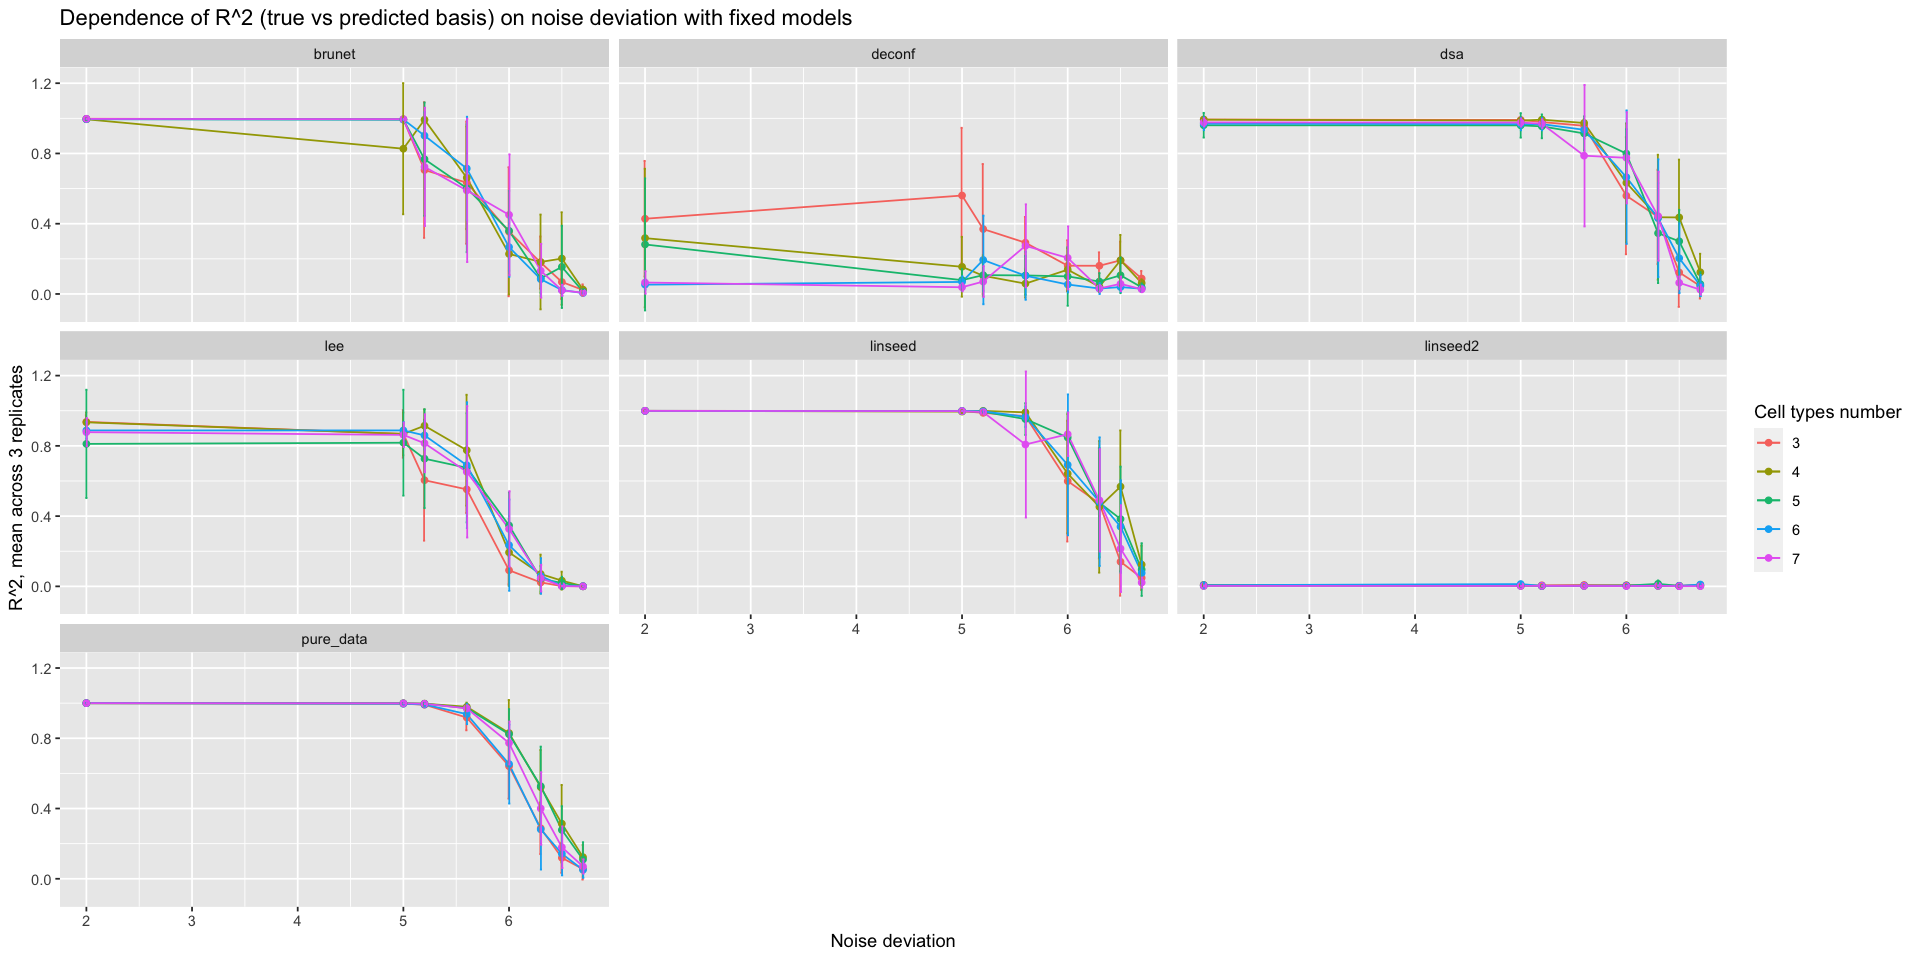

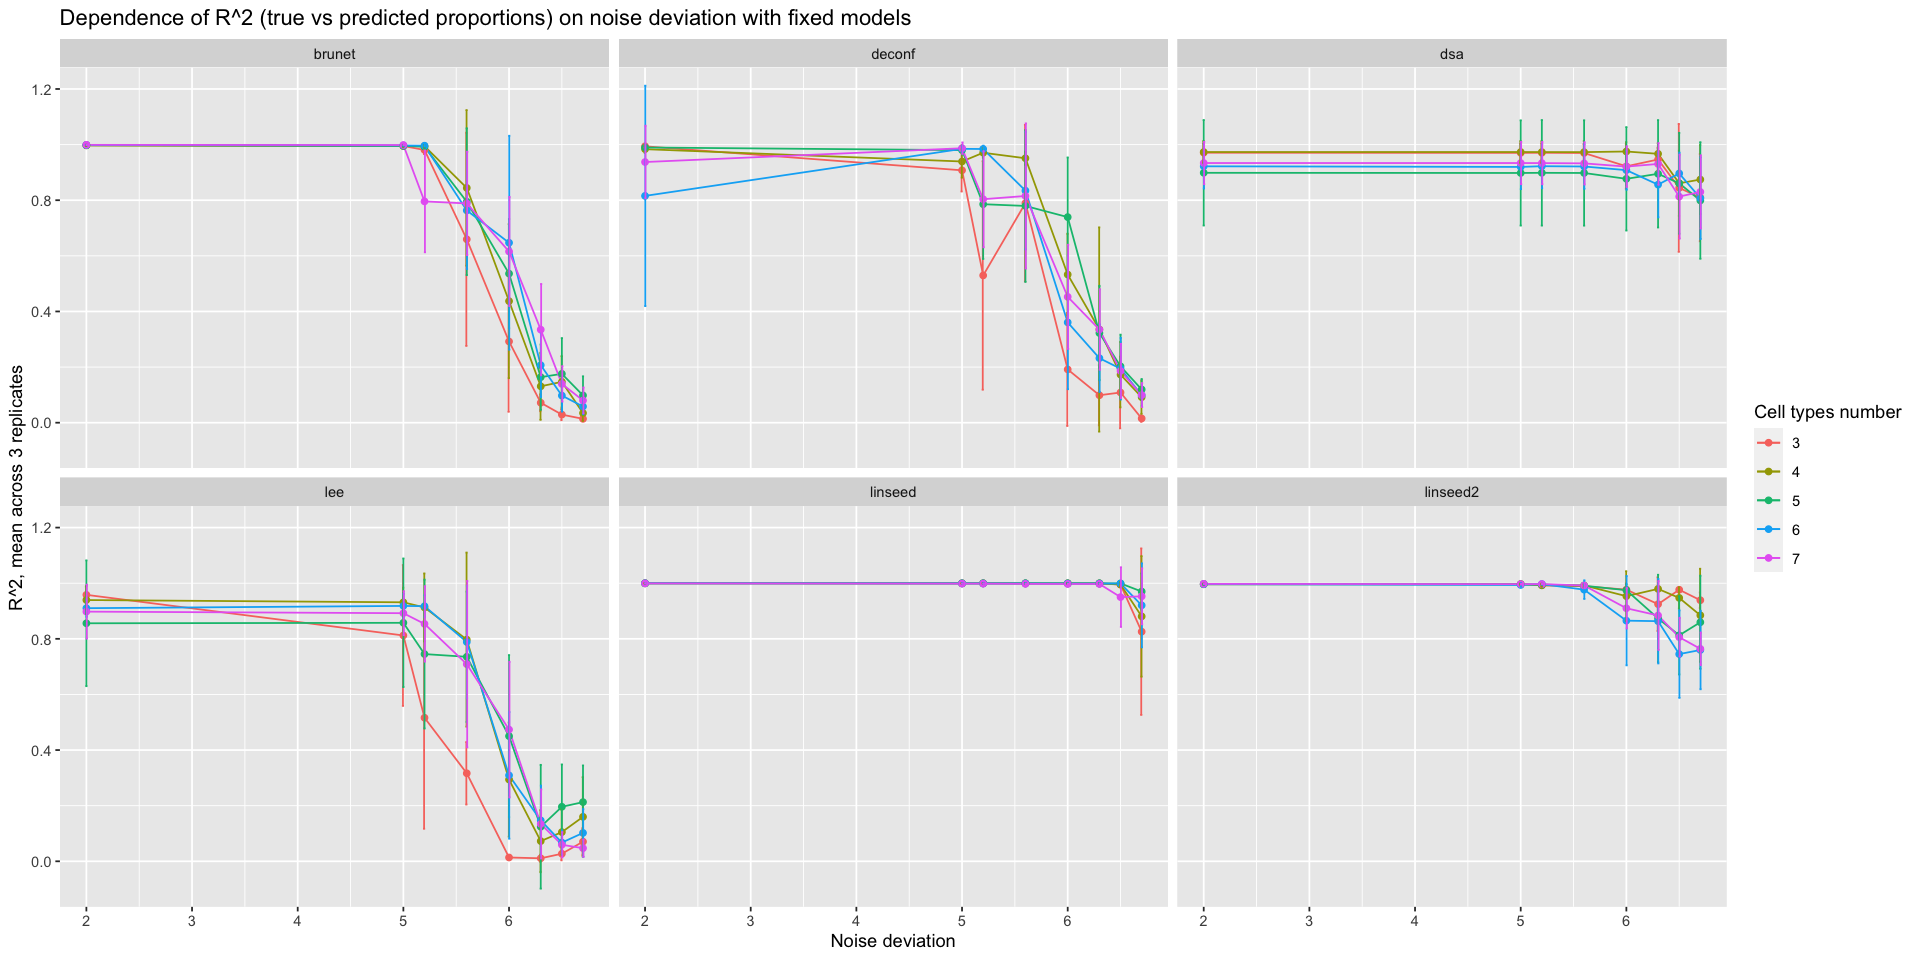

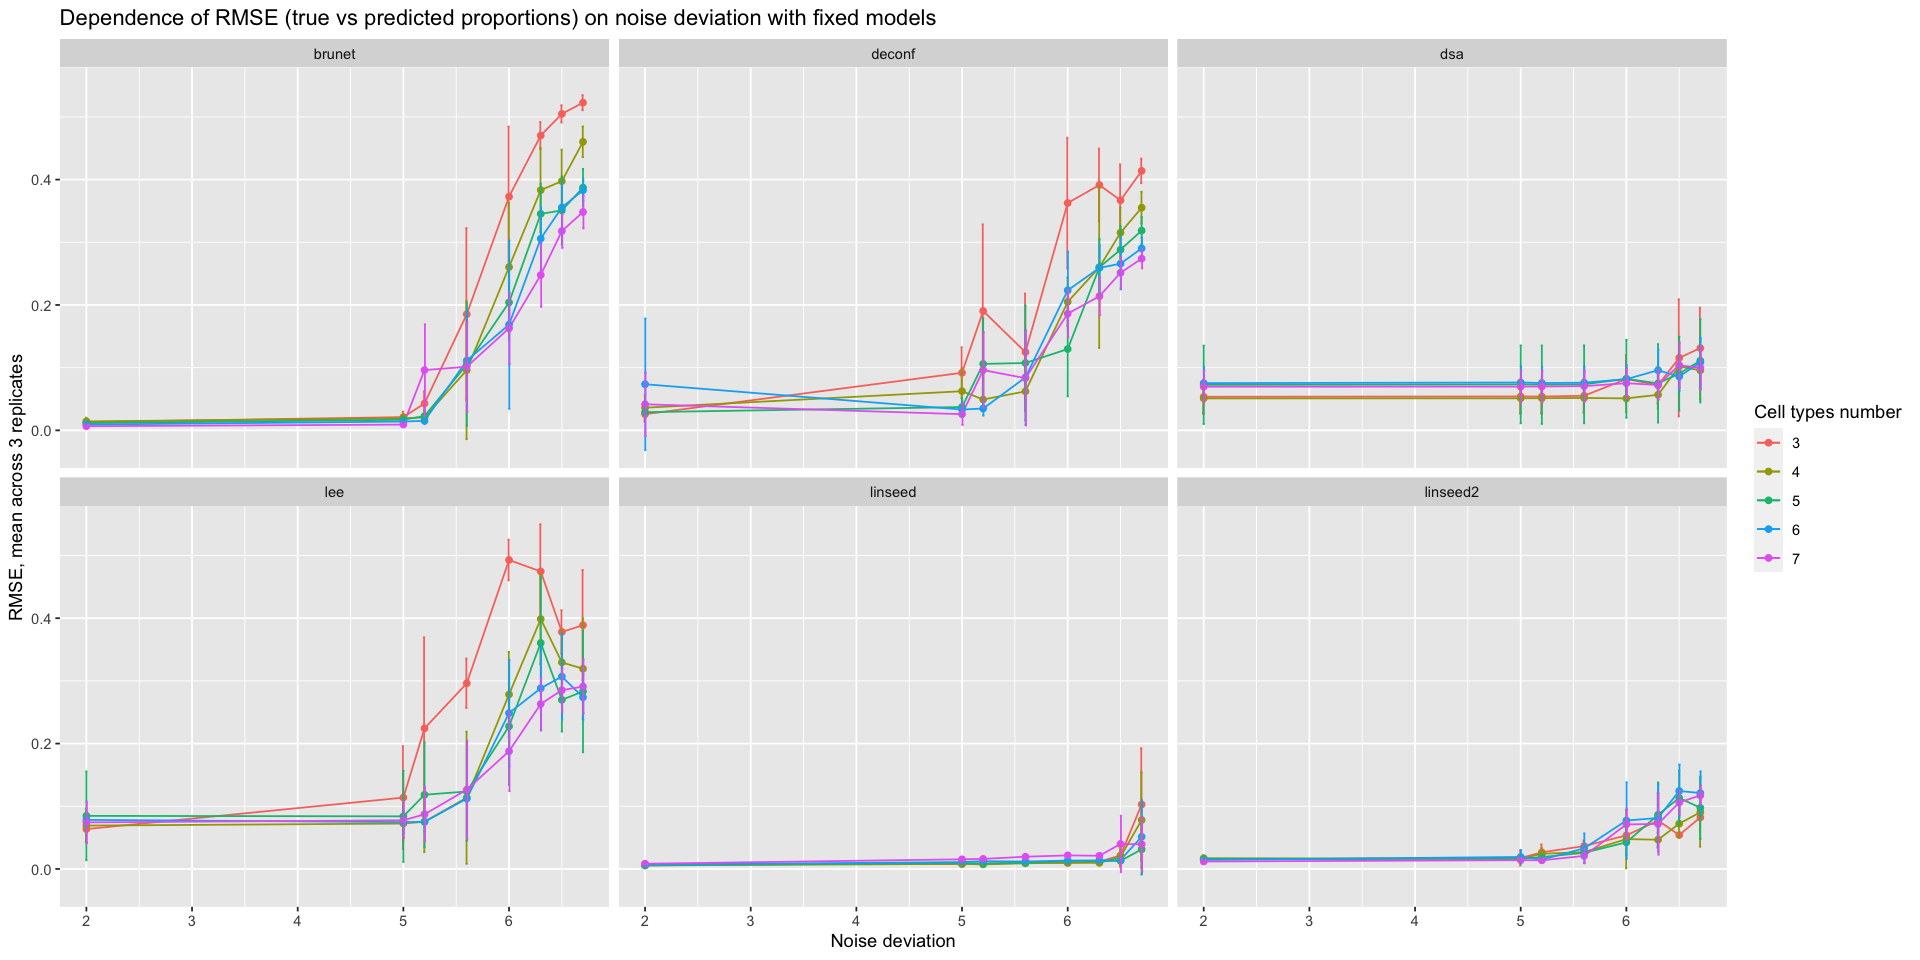

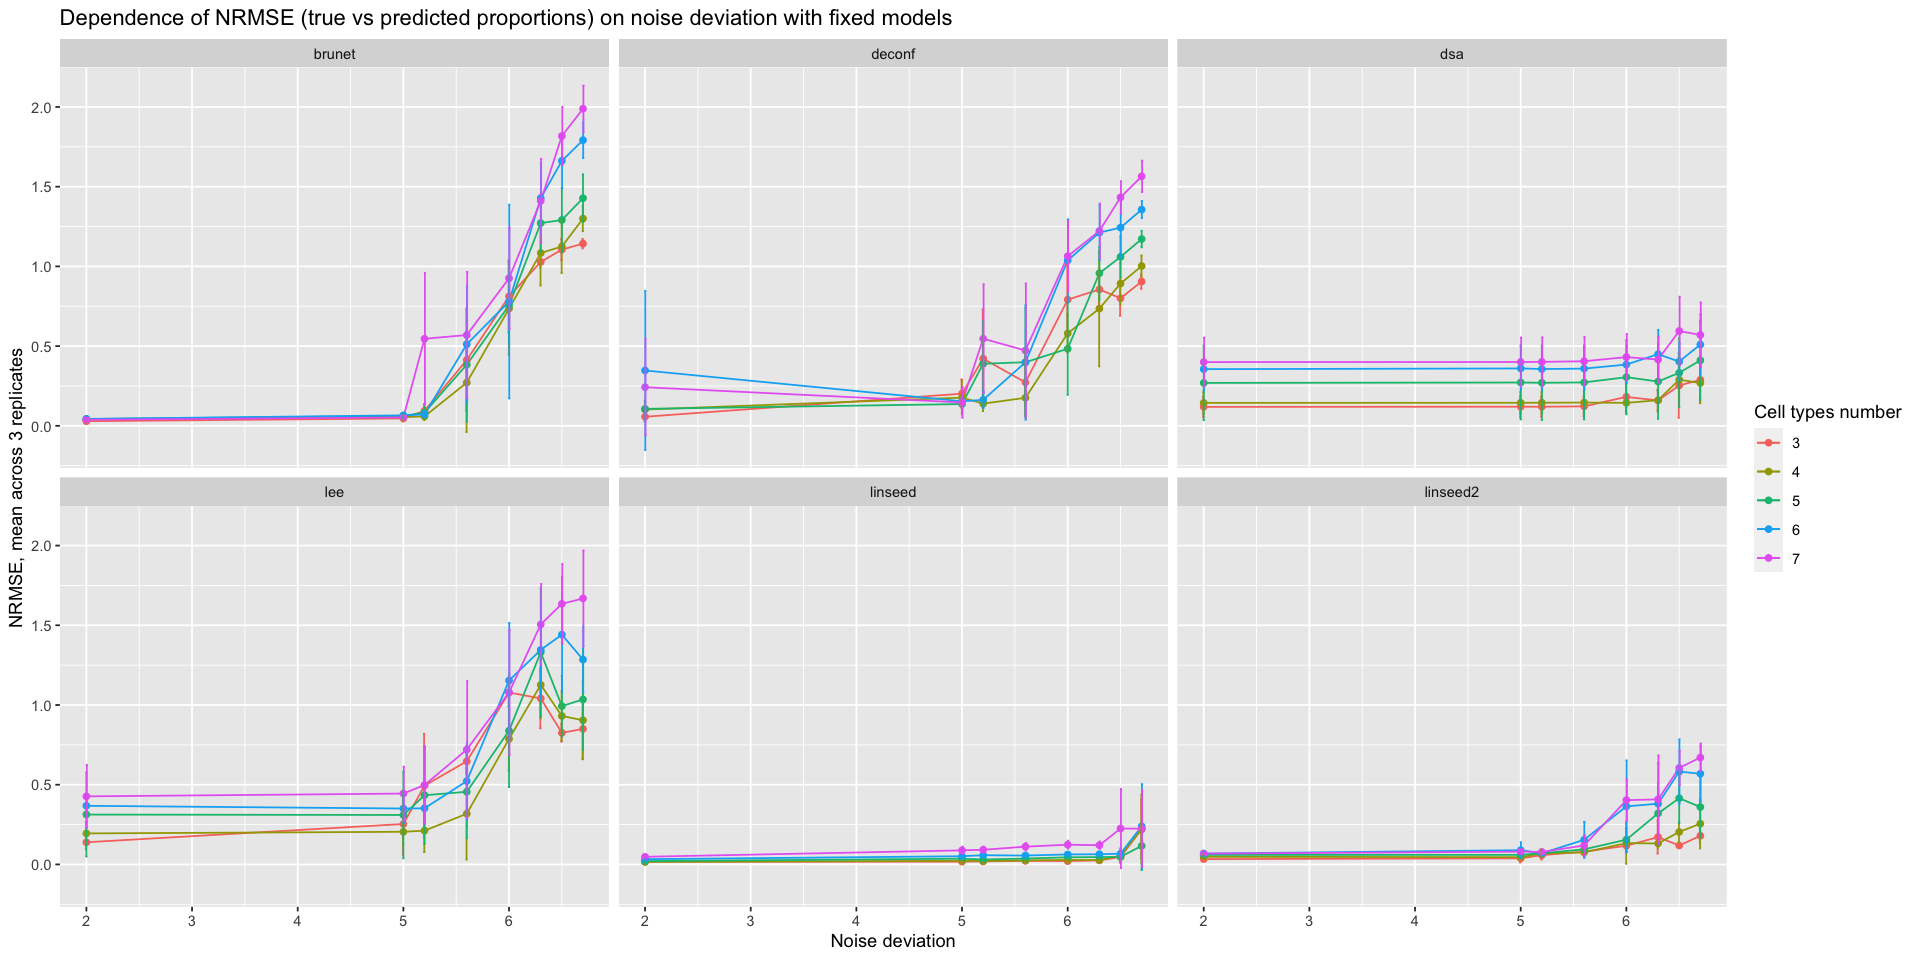

In [84]:
plotAll(dependence_on = "noise", fixed = "model", comparing = "ntypes")

### Metric on number of cell types, fixed model (comparing noise levels)

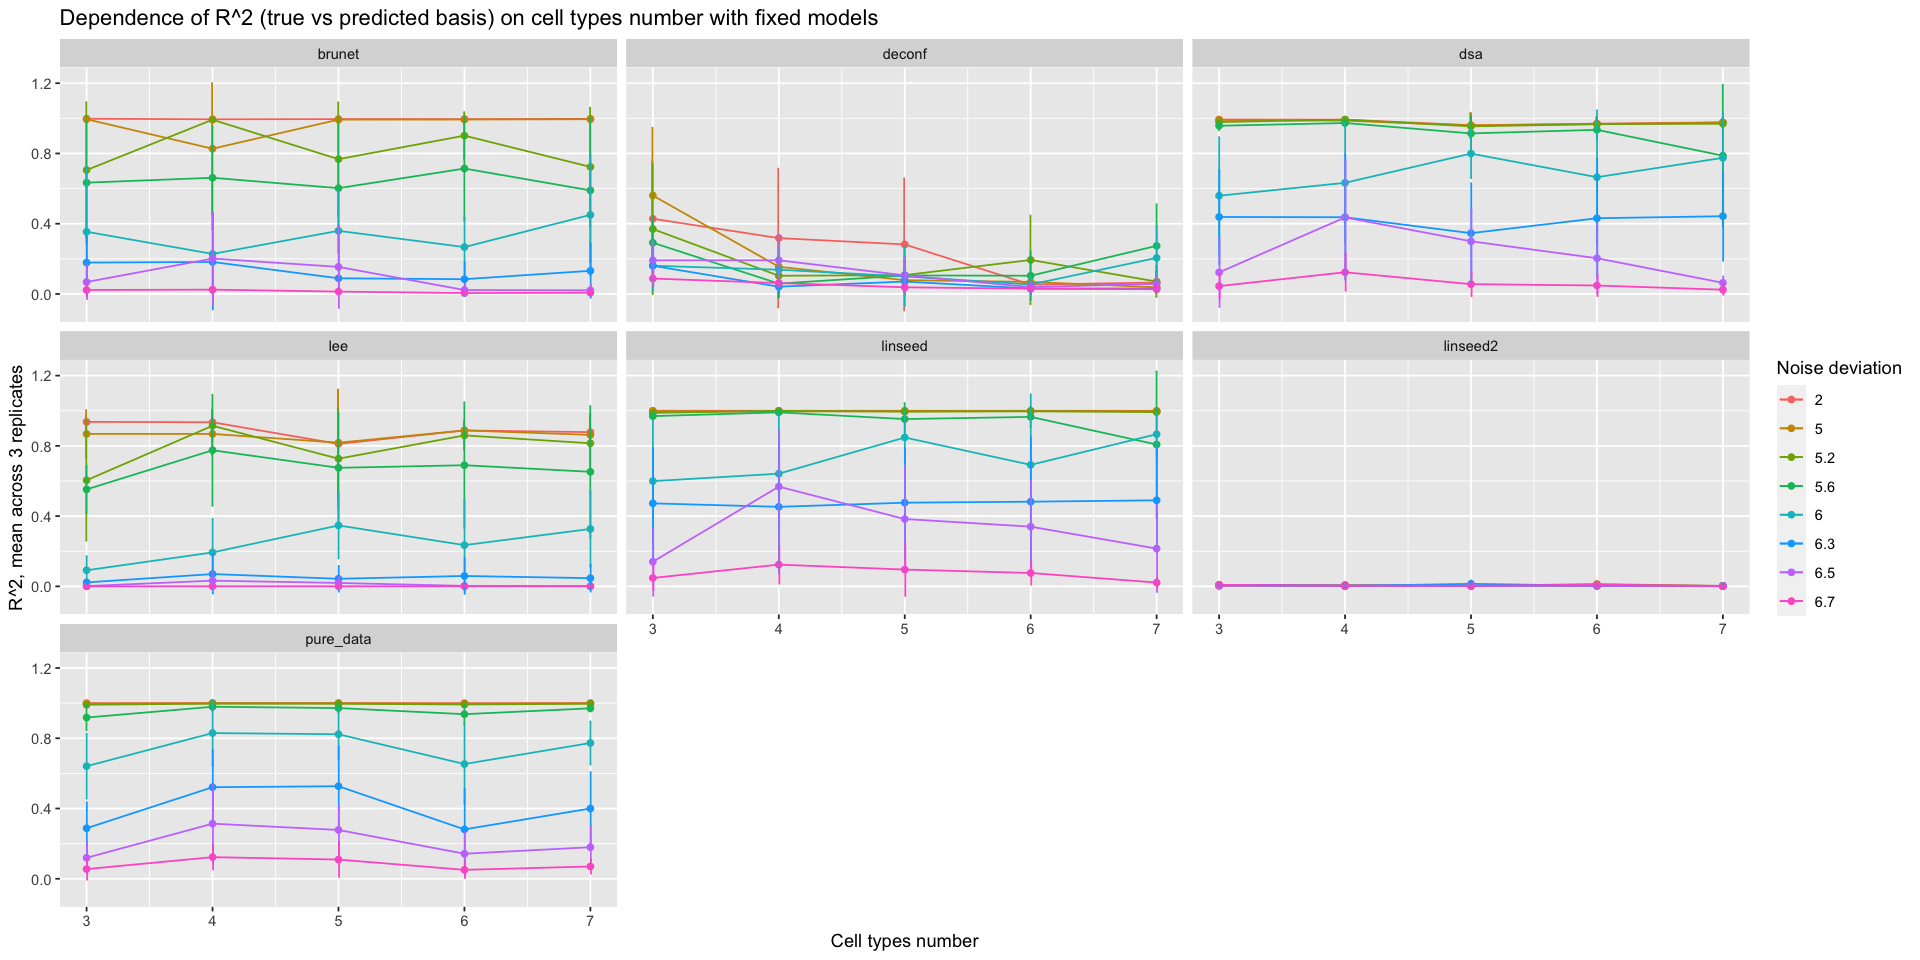

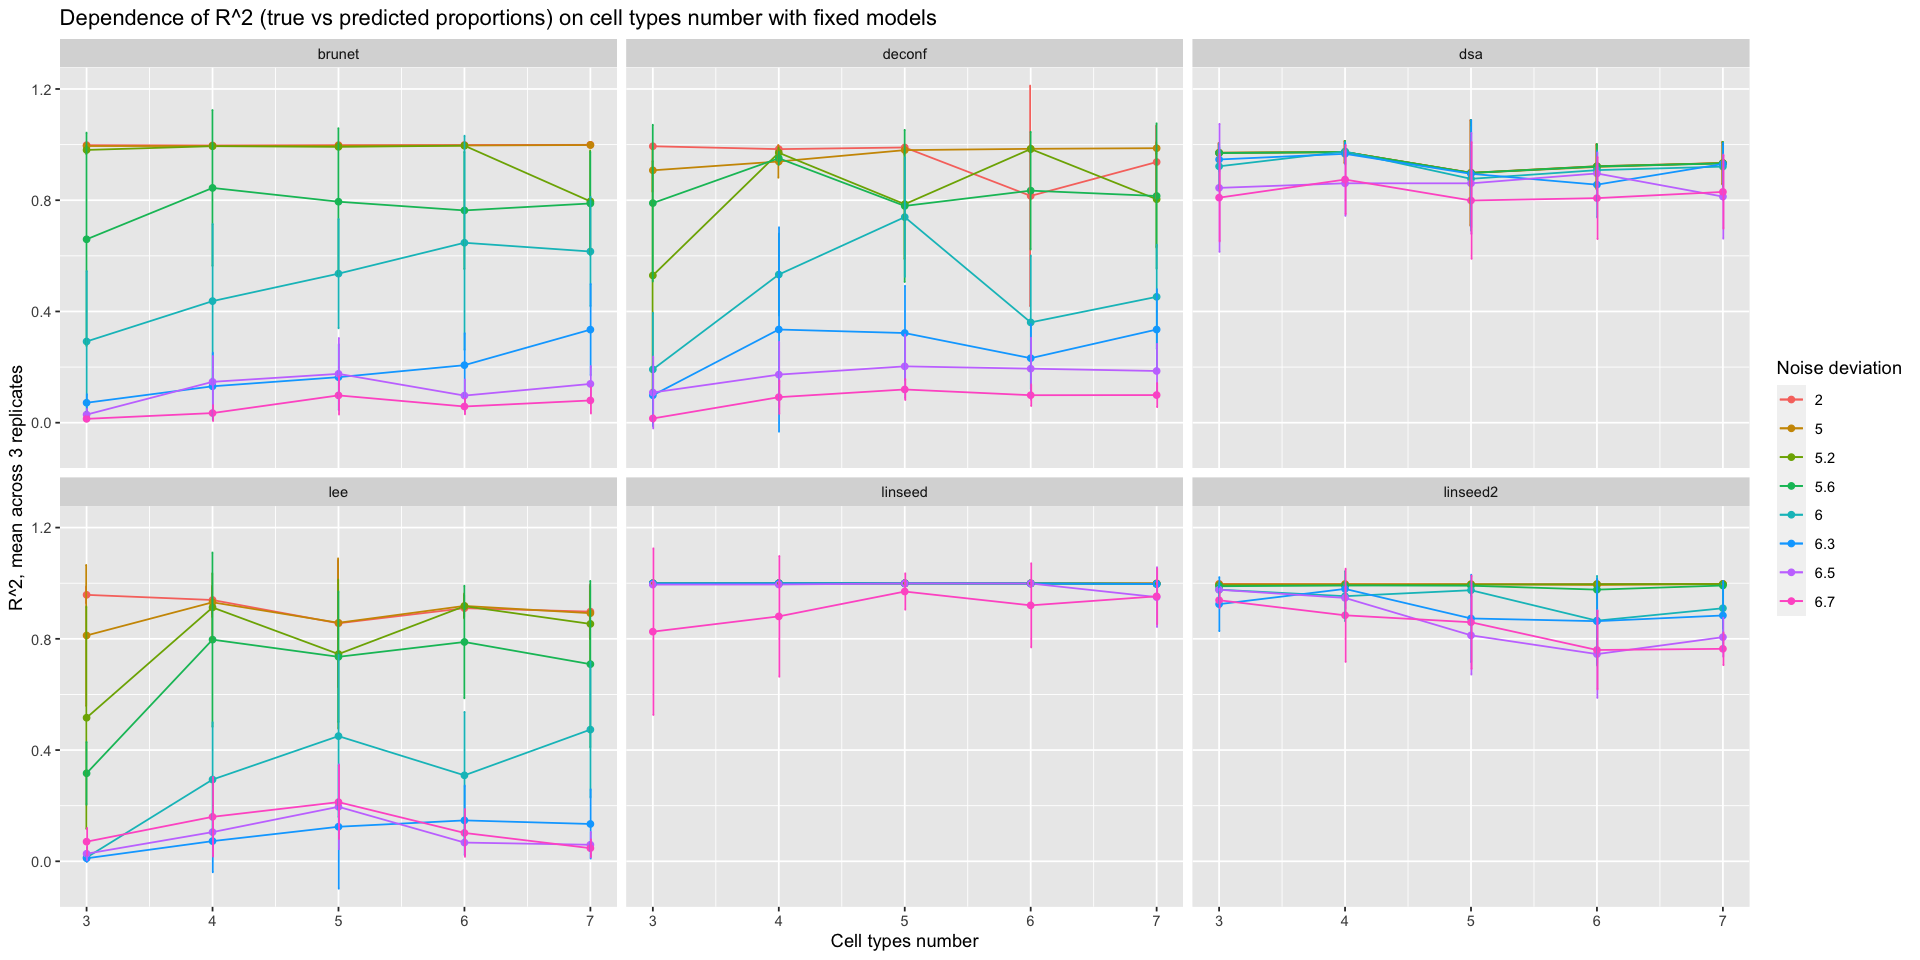

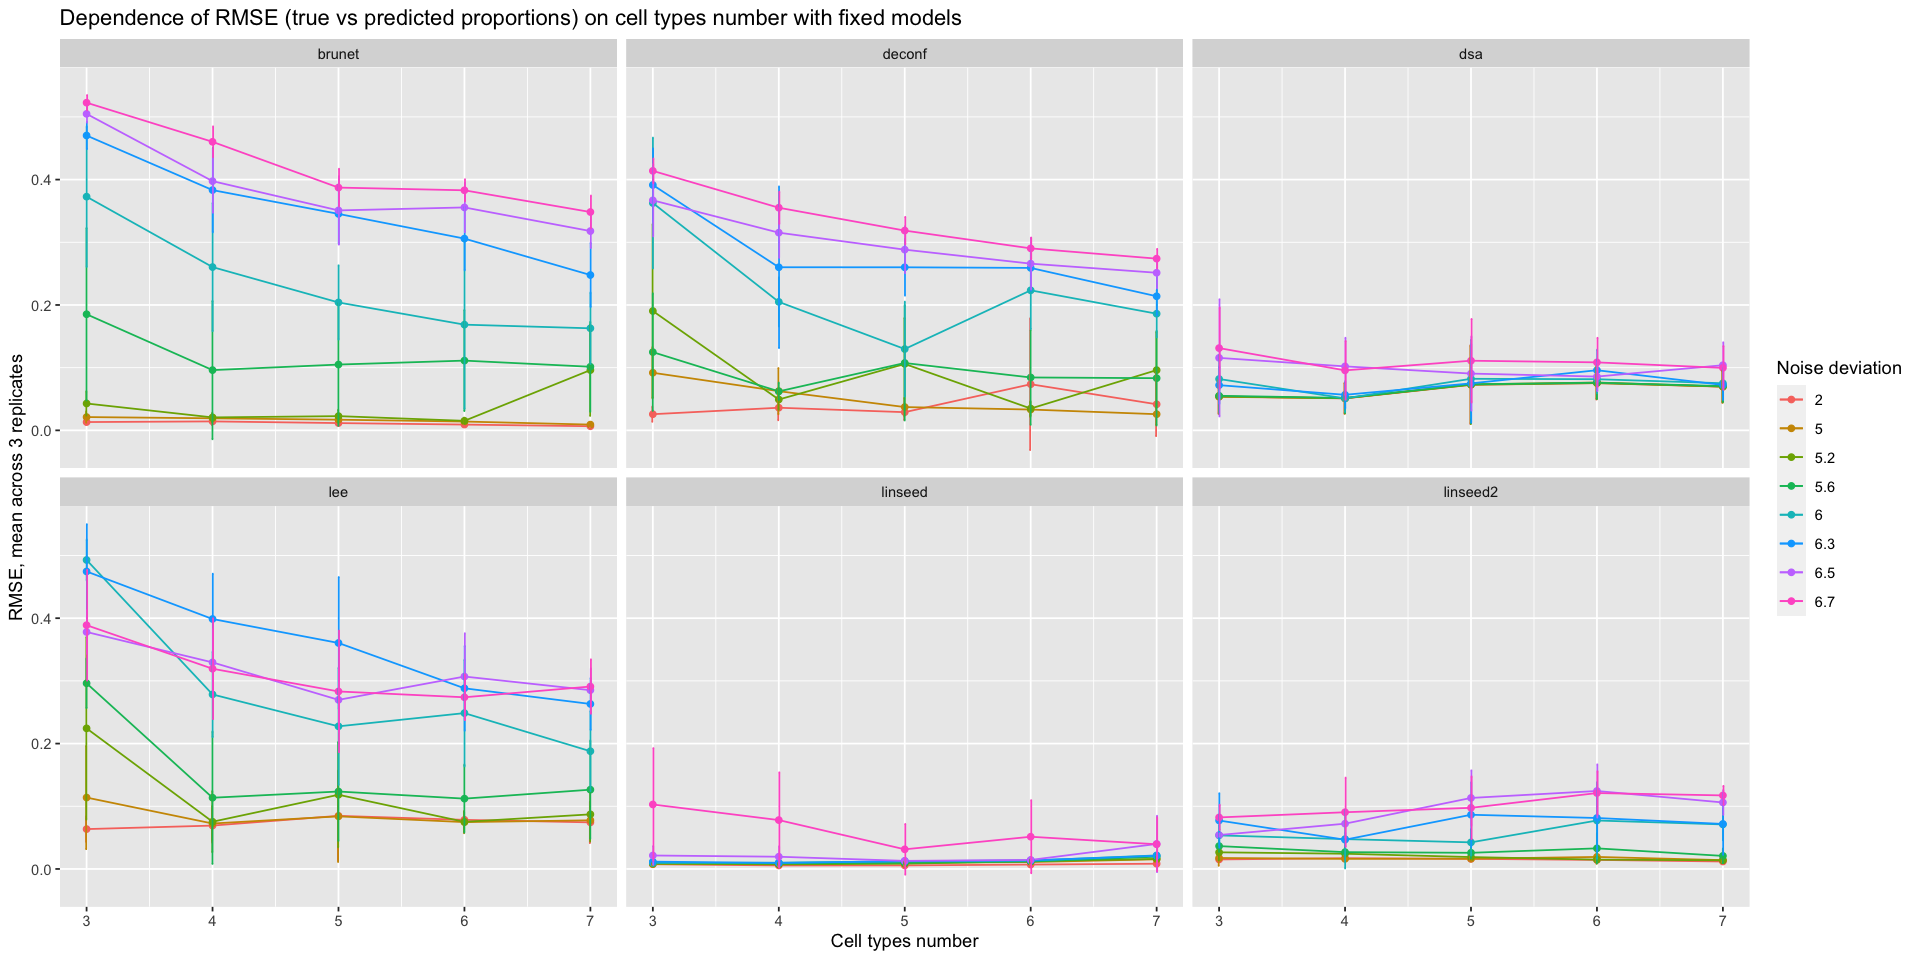

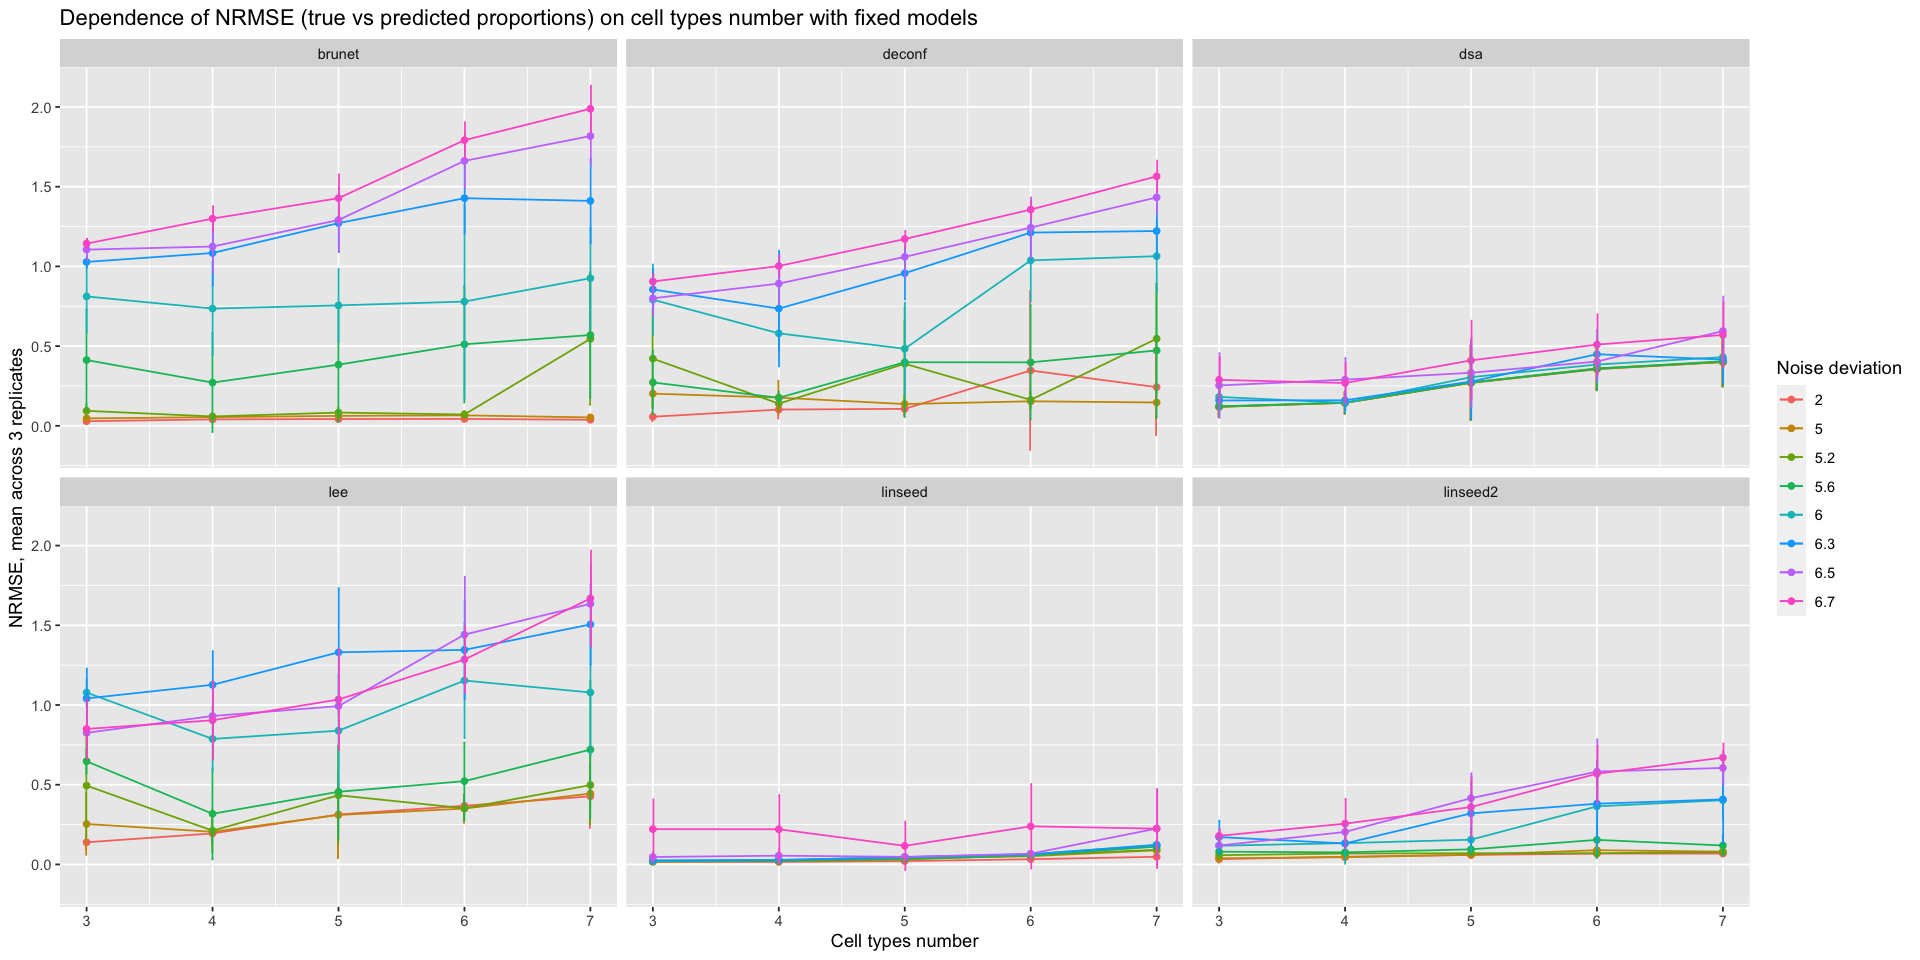

In [81]:
plotAll(dependence_on = "ntypes", fixed = "model", comparing = "noise")

In [386]:
stopCluster(cl)